In [1]:
import pandas as pd
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import yellowbrick
#sn.set(rc={'figure.figsize':(10,5)})

In [2]:
data = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')
data.head

<bound method NDFrame.head of         Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0                0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1                0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2                0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3                0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4                0.0     1.0       1.0        1.0  24.0     0.0     0.0   
...              ...     ...       ...        ...   ...     ...     ...   
253675           0.0     1.0       1.0        1.0  45.0     0.0     0.0   
253676           2.0     1.0       1.0        1.0  18.0     0.0     0.0   
253677           0.0     0.0       0.0        1.0  28.0     0.0     0.0   
253678           0.0     1.0       0.0        1.0  23.0     0.0     0.0   
253679           2.0     1.0       1.0        1.0  25.0     0.0     0.0   

        HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcar

In [3]:
data.isna().sum()

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

In [4]:
data.dtypes

Diabetes_012            float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
AnyHealthcare           float64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                     float64
Age                     float64
Education               float64
Income                  float64
dtype: object

## Variable of Interest

<AxesSubplot: >

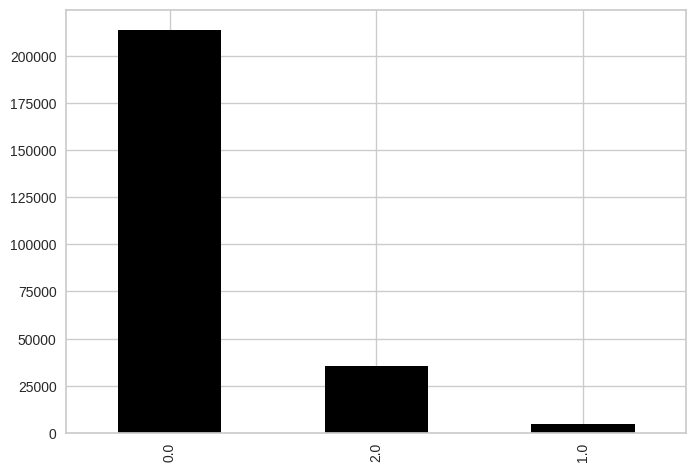

In [5]:
data['Diabetes_012'].value_counts().plot(kind='bar', color='black')

## Continuous Numerical Predictors

We have 3 continuous numerical predictors - BMI, and mental health (number of days where mental health was not good), physical health (number of days where physical health was not good).

### BMI

<AxesSubplot: title={'center': 'BMI'}, ylabel='Frequency'>

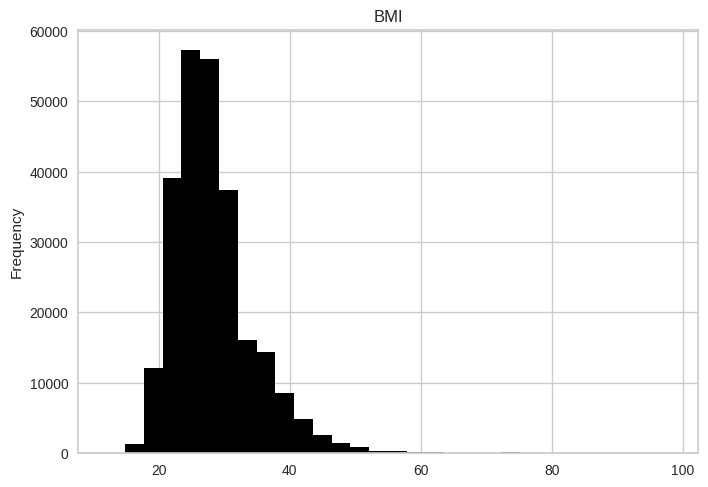

In [6]:
data['BMI'].plot(kind='hist', color='black',bins=30, title='BMI')

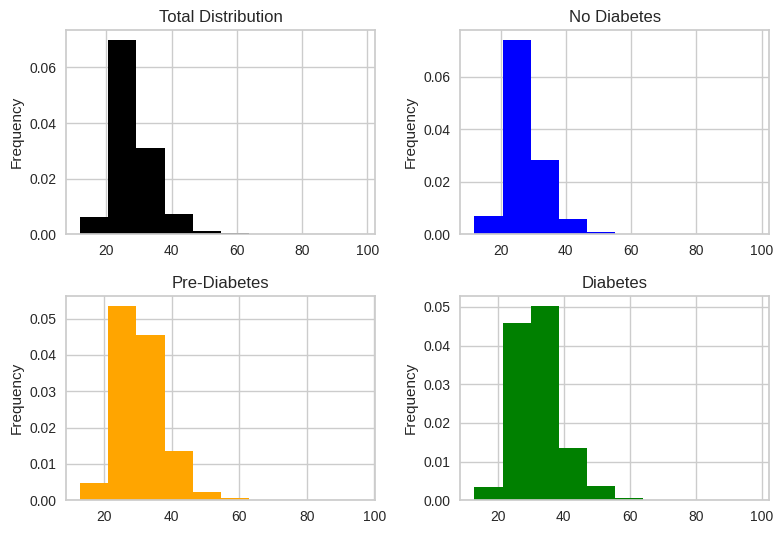

In [7]:
var = 'BMI'

fig, axes = plt.subplots(nrows=2, ncols=2)
data[var].plot(ax=axes[0][0],kind='hist',color='black', density=True).set_title("Total Distribution")
data.query('Diabetes_012 == 0')[var].plot(ax=axes[0][1],kind='hist',color='blue', density=True).set_title("No Diabetes")
data.query('Diabetes_012 == 1')[var].plot(ax=axes[1][0],kind='hist',color='orange', density=True).set_title("Pre-Diabetes")
data.query('Diabetes_012 == 2')[var].plot(ax=axes[1][1],kind='hist',color='green', density=True).set_title("Diabetes")
plt.tight_layout()

In [8]:
#data_copy = data
#data_copy['Diabetes'] = data_copy['Diabetes_012']
#data_copy['Diabetes'] = data_copy['Diabetes'].replace({0.0: '0 - No Diabetes', 1.0: '1 - Pre-Diabetes', 2.0: '2 - Diabetes'})


#data_copy[var].groupby(data_copy['Diabetes']).describe()

In [9]:
data[var].groupby(data['Diabetes_012']).describe()

count       mean       std   min   25%   50%   75%   max
Diabetes_012                                                             
0.0           213703.0  27.742521  6.260993  12.0  24.0  27.0  30.0  98.0
1.0             4631.0  30.724466  6.964898  13.0  26.0  30.0  34.0  96.0
2.0            35346.0  31.944011  7.363401  13.0  27.0  31.0  35.0  98.0

In [10]:
# One-Way ANOVA - Test of Variance Between Groups
nodiab = data.query('Diabetes_012 == 0')[var]
prediab = data.query('Diabetes_012 == 1')[var]
diab = data.query('Diabetes_012 == 2')[var]

stats.f_oneway(nodiab, prediab, diab)

F_onewayResult(statistic=6768.361066999288, pvalue=0.0)

<AxesSubplot: xlabel='Diabetes_012', ylabel='BMI'>

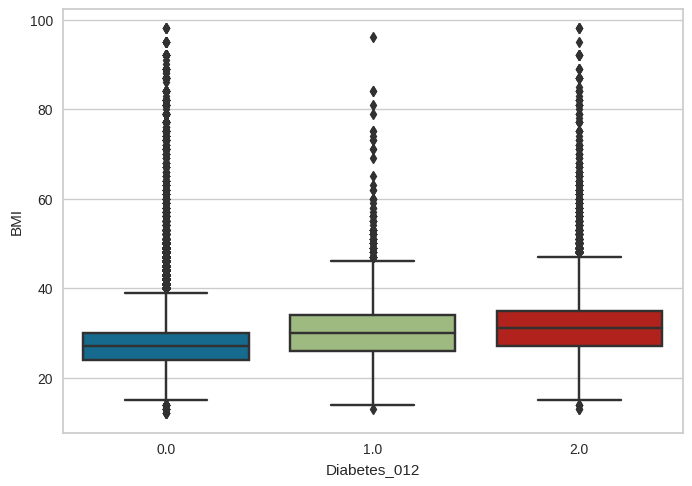

In [11]:
sn.boxplot(x='Diabetes_012', y=var, data=data)

Let's transform this variable - there are quite a few outliers which might make convergence difficult later. Let's transform this to mirror the categories used in the field:

below 18.5 - This is described as underweight.

between 18.5 and 24.9 – This is described as the 'healthy range'. 

between 25 and 29.9 – This is described as overweight. 

30 and above - This is described as obesity.

source: https://www.nhsinform.scot/healthy-living/food-and-nutrition/healthy-eating-and-weight-loss/body-mass-index-bmi#:~:text=BMI%20ranges&text=between%2018.5%20and%2024.9%20%E2%80%93%20This,is%20described%20as%20severe%20obesity

In [12]:
data['BMI'].mask(data['BMI'] < 18.5, 0, inplace=True)
data['BMI'].mask((data['BMI'] >= 18.5) & (data['BMI'] <= 24.9), 1, inplace=True)
data['BMI'].mask((data['BMI'] >= 25) & (data['BMI'] <= 29.9), 2, inplace=True)
data['BMI'].mask((data['BMI'] >= 30) & (data['BMI'] <= 34.9), 3, inplace=True)
data['BMI'].mask((data['BMI'] >= 35) & (data['BMI'] <= 39.9), 4, inplace=True)
data['BMI'].mask((data['BMI'] >= 40), 5, inplace=True)

Text(0.5, 1.0, 'Diabetes')

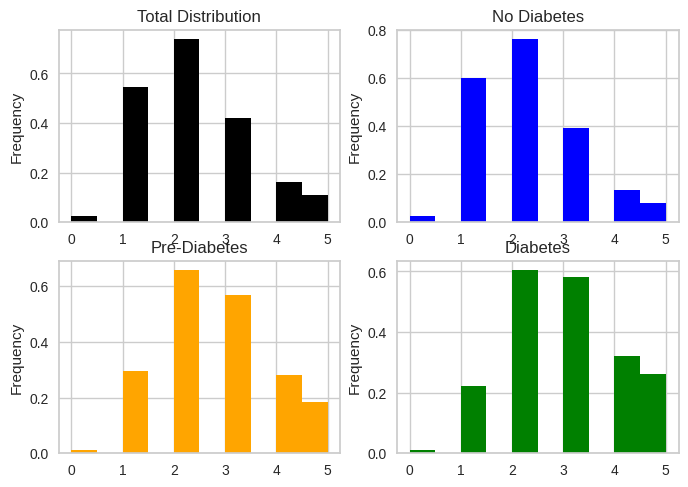

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2)
data[var].plot(ax=axes[0][0],kind='hist',color='black', density=True).set_title("Total Distribution")
data.query('Diabetes_012 == 0')[var].plot(ax=axes[0][1],kind='hist',color='blue', density=True).set_title("No Diabetes")
data.query('Diabetes_012 == 1')[var].plot(ax=axes[1][0],kind='hist',color='orange', density=True).set_title("Pre-Diabetes")
data.query('Diabetes_012 == 2')[var].plot(ax=axes[1][1],kind='hist',color='green', density=True).set_title("Diabetes")

In [14]:
data[var].groupby(data['Diabetes_012']).describe()

count      mean       std  min  25%  50%  75%  max
Diabetes_012                                                       
0.0           213703.0  2.123845  1.082381  0.0  1.0  2.0  3.0  5.0
1.0             4631.0  2.678255  1.175947  0.0  2.0  3.0  3.0  5.0
2.0            35346.0  2.881967  1.207436  0.0  2.0  3.0  4.0  5.0

### Mental Health

count  mean  std   min   25%   50%   75%   max
MentHlth                                                   
0.0       175680.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0
1.0         8538.0   1.0  0.0   1.0   1.0   1.0   1.0   1.0
2.0        13054.0   2.0  0.0   2.0   2.0   2.0   2.0   2.0
3.0         7381.0   3.0  0.0   3.0   3.0   3.0   3.0   3.0
4.0         3789.0   4.0  0.0   4.0   4.0   4.0   4.0   4.0
5.0         9030.0   5.0  0.0   5.0   5.0   5.0   5.0   5.0
6.0          988.0   6.0  0.0   6.0   6.0   6.0   6.0   6.0
7.0         3100.0   7.0  0.0   7.0   7.0   7.0   7.0   7.0
8.0          639.0   8.0  0.0   8.0   8.0   8.0   8.0   8.0
9.0           91.0   9.0  0.0   9.0   9.0   9.0   9.0   9.0
10.0        6373.0  10.0  0.0  10.0  10.0  10.0  10.0  10.0
11.0          41.0  11.0  0.0  11.0  11.0  11.0  11.0  11.0
12.0         398.0  12.0  0.0  12.0  12.0  12.0  12.0  12.0
13.0          41.0  13.0  0.0  13.0  13.0  13.0  13.0  13.0
14.0        1167.0  14.0  0.0  14.0  14.0  14.0  14.0  14.0
15.0        5505.0  15.0  0.0  15.0  15.0  15.0  15.0  15.0
16.0          88.0  16.0  0.0  16.0  16.0  16.0  16.0  16.0
17.0          54.0  17.0  0.0  17.0  17.0  17.0  17.0  17.0
18.0          97.0  18.0  0.0  18.0  18.0  18.0  18.0  18.0
19.0          16.0  19.0  0.0  19.0  19.0  19.0  19.0  19.0
20.0        3364.0  20.0  0.0  20.0  20.0  20.0  20.0  20.0
21.0         227.0  21.0  0.0  21.0  21.0  21.0  21.0  21.0
22.0          63.0  22.0  0.0  22.0  22.0  22.0  22.0  22.0
23.0          38.0  23.0  0.0  23.0  23.0  23.0  23.0  23.0
24.0          33.0  24.0  0.0  24.0  24.0  24.0  24.0  24.0
25.0        1188.0  25.0  0.0  25.0  25.0  25.0  25.0  25.0
26.0          45.0  26.0  0.0  26.0  26.0  26.0  26.0  26.0
27.0          79.0  27.0  0.0  27.0  27.0  27.0  27.0  27.0
28.0         327.0  28.0  0.0  28.0  28.0  28.0  28.0  28.0
29.0         158.0  29.0  0.0  29.0  29.0  29.0  29.0  29.0
30.0       12088.0  30.0  0.0  30.0  30.0  30.0  30.0  30.0

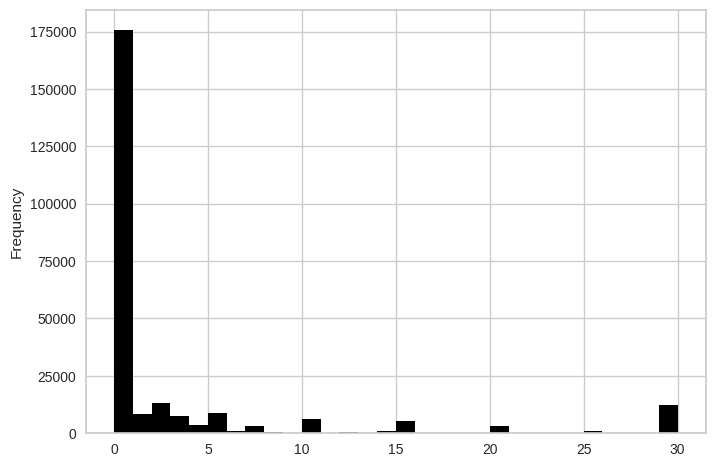

In [15]:
var='MentHlth'
data[var].plot(kind='hist', color='black',bins=30)

data[var].groupby(data[var]).describe()


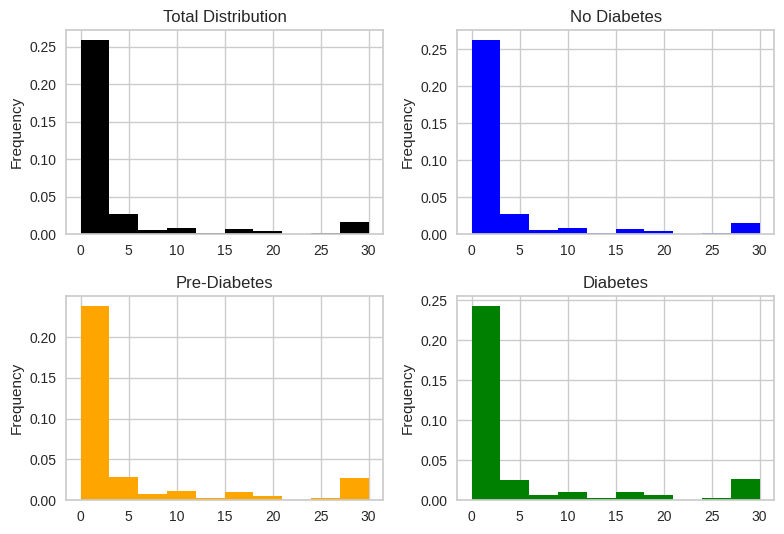

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2)
data[var].plot(ax=axes[0][0],kind='hist',color='black', density=True).set_title("Total Distribution")
data.query('Diabetes_012 == 0')[var].plot(ax=axes[0][1],kind='hist',color='blue', density=True).set_title("No Diabetes")
data.query('Diabetes_012 == 1')[var].plot(ax=axes[1][0],kind='hist',color='orange', density=True).set_title("Pre-Diabetes")
data.query('Diabetes_012 == 2')[var].plot(ax=axes[1][1],kind='hist',color='green', density=True).set_title("Diabetes")
plt.tight_layout()

In [17]:
data[var].groupby(data['Diabetes_012']).describe()

count      mean       std  min  25%  50%  75%   max
Diabetes_012                                                        
0.0           213703.0  2.944404  7.064440  0.0  0.0  0.0  2.0  30.0
1.0             4631.0  4.529907  8.897176  0.0  0.0  0.0  4.0  30.0
2.0            35346.0  4.461806  8.947717  0.0  0.0  0.0  3.0  30.0

In [18]:
# One-Way ANOVA - Test of Variance Between Groups
nodiab = data.query('Diabetes_012 == 0')[var]
prediab = data.query('Diabetes_012 == 1')[var]
diab = data.query('Diabetes_012 == 2')[var]

stats.f_oneway(nodiab, prediab, diab)

F_onewayResult(statistic=717.1173715522025, pvalue=2.735178567403e-311)

<AxesSubplot: xlabel='Diabetes_012', ylabel='MentHlth'>

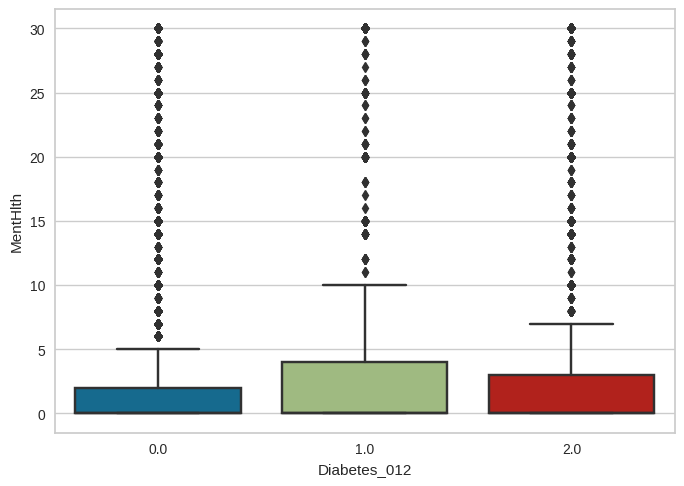

In [19]:
sn.boxplot(x='Diabetes_012', y=var, data=data)

There are a large number of outliers in the dataset, where very few people experience most days of mental health not being good. 
This is likely to cause issues with our model, so we can either transform the variable to be categorical or we can drop it. 

Evidence suggests that people experience roughly 4 days of poor mental health per month. So we will say 'poor mental health' as anything above 4 days a month.
source: 
https://www.shadac.org/news/measuring-unhealthy-days-SHC

In [20]:
data[var].mask(data[var] == 0, 0, inplace=True)
data[var].mask(data[var] > 0, 1, inplace=True)

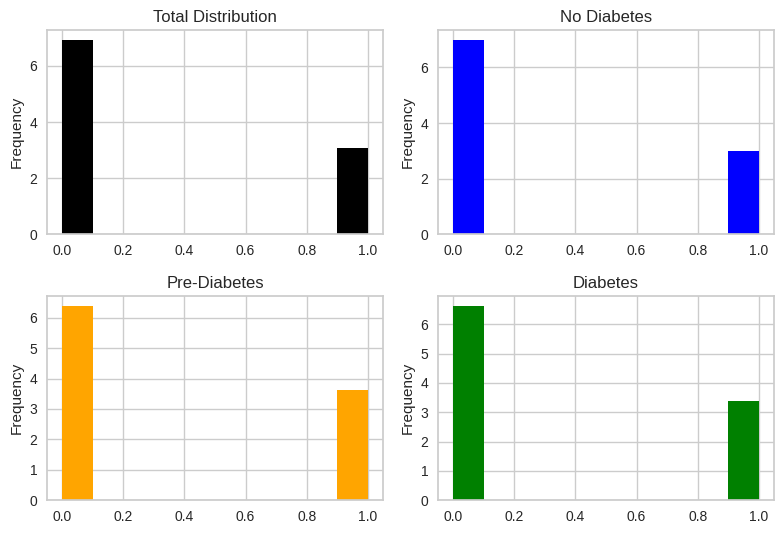

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2)
data[var].plot(ax=axes[0][0],kind='hist',color='black', density=True).set_title("Total Distribution")
data.query('Diabetes_012 == 0')[var].plot(ax=axes[0][1],kind='hist',color='blue', density=True).set_title("No Diabetes")
data.query('Diabetes_012 == 1')[var].plot(ax=axes[1][0],kind='hist',color='orange', density=True).set_title("Pre-Diabetes")
data.query('Diabetes_012 == 2')[var].plot(ax=axes[1][1],kind='hist',color='green', density=True).set_title("Diabetes")
plt.tight_layout()

In [22]:
data[var].groupby(data['Diabetes_012']).describe()

count      mean       std  min  25%  50%  75%  max
Diabetes_012                                                       
0.0           213703.0  0.301269  0.458810  0.0  0.0  0.0  1.0  1.0
1.0             4631.0  0.361693  0.480542  0.0  0.0  0.0  1.0  1.0
2.0            35346.0  0.337888  0.472997  0.0  0.0  0.0  1.0  1.0

### Physical Health

count  mean  std   min   25%   50%   75%   max
PhysHlth                                                   
0.0       160052.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0
1.0        11388.0   1.0  0.0   1.0   1.0   1.0   1.0   1.0
2.0        14764.0   2.0  0.0   2.0   2.0   2.0   2.0   2.0
3.0         8495.0   3.0  0.0   3.0   3.0   3.0   3.0   3.0
4.0         4542.0   4.0  0.0   4.0   4.0   4.0   4.0   4.0
5.0         7622.0   5.0  0.0   5.0   5.0   5.0   5.0   5.0
6.0         1330.0   6.0  0.0   6.0   6.0   6.0   6.0   6.0
7.0         4538.0   7.0  0.0   7.0   7.0   7.0   7.0   7.0
8.0          809.0   8.0  0.0   8.0   8.0   8.0   8.0   8.0
9.0          179.0   9.0  0.0   9.0   9.0   9.0   9.0   9.0
10.0        5595.0  10.0  0.0  10.0  10.0  10.0  10.0  10.0
11.0          60.0  11.0  0.0  11.0  11.0  11.0  11.0  11.0
12.0         578.0  12.0  0.0  12.0  12.0  12.0  12.0  12.0
13.0          68.0  13.0  0.0  13.0  13.0  13.0  13.0  13.0
14.0        2587.0  14.0  0.0  14.0  14.0  14.0  14.0  14.0
15.0        4916.0  15.0  0.0  15.0  15.0  15.0  15.0  15.0
16.0         112.0  16.0  0.0  16.0  16.0  16.0  16.0  16.0
17.0          96.0  17.0  0.0  17.0  17.0  17.0  17.0  17.0
18.0         152.0  18.0  0.0  18.0  18.0  18.0  18.0  18.0
19.0          22.0  19.0  0.0  19.0  19.0  19.0  19.0  19.0
20.0        3273.0  20.0  0.0  20.0  20.0  20.0  20.0  20.0
21.0         663.0  21.0  0.0  21.0  21.0  21.0  21.0  21.0
22.0          70.0  22.0  0.0  22.0  22.0  22.0  22.0  22.0
23.0          56.0  23.0  0.0  23.0  23.0  23.0  23.0  23.0
24.0          72.0  24.0  0.0  24.0  24.0  24.0  24.0  24.0
25.0        1336.0  25.0  0.0  25.0  25.0  25.0  25.0  25.0
26.0          69.0  26.0  0.0  26.0  26.0  26.0  26.0  26.0
27.0          99.0  27.0  0.0  27.0  27.0  27.0  27.0  27.0
28.0         522.0  28.0  0.0  28.0  28.0  28.0  28.0  28.0
29.0         215.0  29.0  0.0  29.0  29.0  29.0  29.0  29.0
30.0       19400.0  30.0  0.0  30.0  30.0  30.0  30.0  30.0

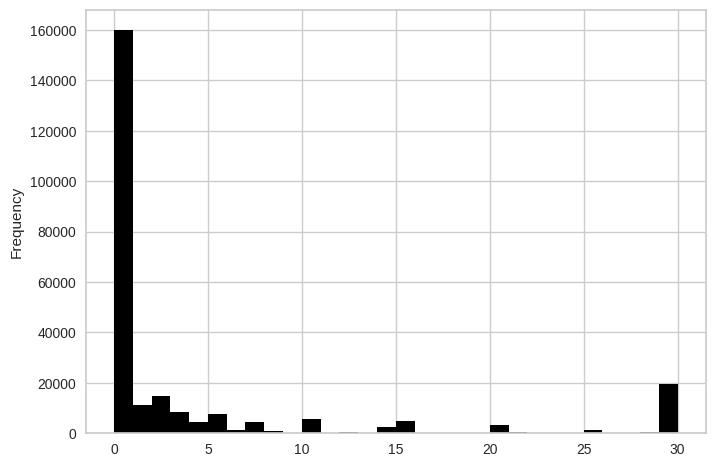

In [23]:
var='PhysHlth'
data[var].plot(kind='hist', color='black',bins=30)
data[var].groupby(data[var]).describe()

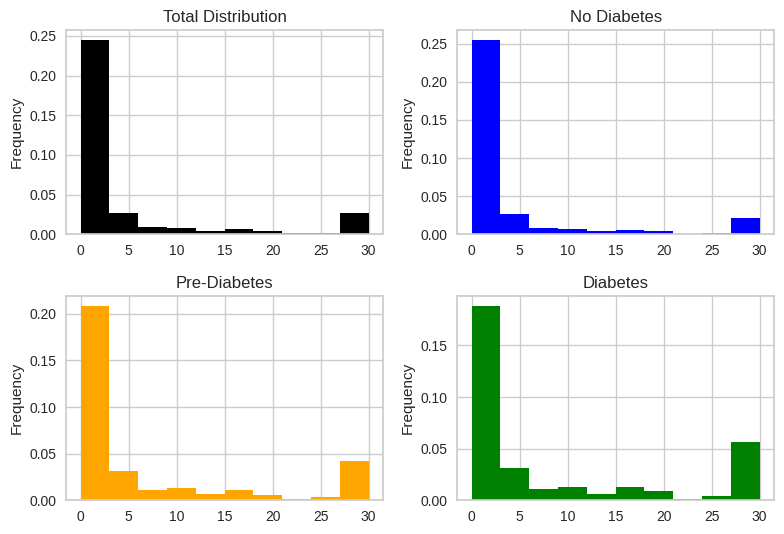

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2)
data[var].plot(ax=axes[0][0],kind='hist',color='black', density=True).set_title("Total Distribution")
data.query('Diabetes_012 == 0')[var].plot(ax=axes[0][1],kind='hist',color='blue', density=True).set_title("No Diabetes")
data.query('Diabetes_012 == 1')[var].plot(ax=axes[1][0],kind='hist',color='orange', density=True).set_title("Pre-Diabetes")
data.query('Diabetes_012 == 2')[var].plot(ax=axes[1][1],kind='hist',color='green', density=True).set_title("Diabetes")
plt.tight_layout()

In [25]:
data[var].groupby(data['Diabetes_012']).describe()

count      mean        std  min  25%  50%   75%   max
Diabetes_012                                                          
0.0           213703.0  3.582416   7.999205  0.0  0.0  0.0   2.0  30.0
1.0             4631.0  6.348305  10.298013  0.0  0.0  0.0   8.0  30.0
2.0            35346.0  7.954479  11.301491  0.0  0.0  1.0  15.0  30.0

In [26]:
# One-Way ANOVA - Test of Variance Between Groups
nodiab = data.query('Diabetes_012 == 0')[var]
prediab = data.query('Diabetes_012 == 1')[var]
diab = data.query('Diabetes_012 == 2')[var]

stats.f_oneway(nodiab, prediab, diab)

F_onewayResult(statistic=4078.699854188424, pvalue=0.0)

<AxesSubplot: xlabel='Diabetes_012', ylabel='PhysHlth'>

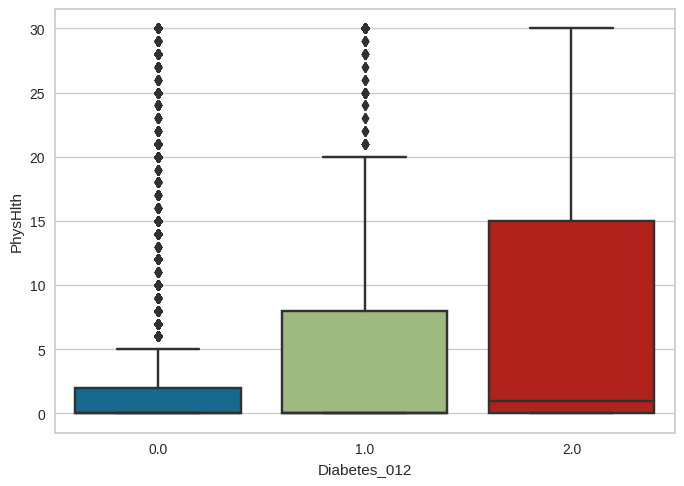

In [27]:
sn.boxplot(x='Diabetes_012', y=var, data=data)

There are a large number of outliers in the dataset, where very few people experience most days of physical health not being good. 
This is likely to cause issues with our model, so we can either transform the variable to be categorical or we can drop it. 

Evidence suggests that people experience roughly 4 days of poor physical health per month. So we will say 'poor mental health' as anything above 4 days a month.
source: 
https://www.shadac.org/news/measuring-unhealthy-days-SHC

In [28]:
data[var].mask(data[var] == 0, 0, inplace=True)
data[var].mask(data[var] > 0, 1, inplace=True)

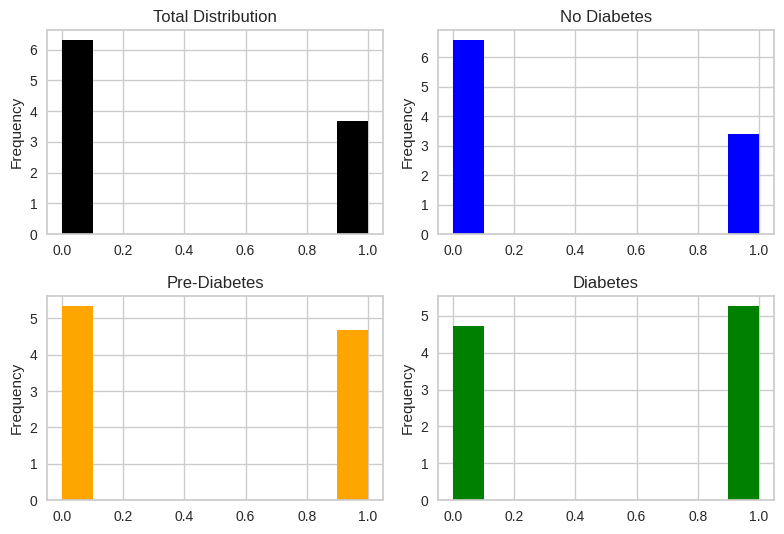

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=2)
data[var].plot(ax=axes[0][0],kind='hist',color='black', density=True).set_title("Total Distribution")
data.query('Diabetes_012 == 0')[var].plot(ax=axes[0][1],kind='hist',color='blue', density=True).set_title("No Diabetes")
data.query('Diabetes_012 == 1')[var].plot(ax=axes[1][0],kind='hist',color='orange', density=True).set_title("Pre-Diabetes")
data.query('Diabetes_012 == 2')[var].plot(ax=axes[1][1],kind='hist',color='green', density=True).set_title("Diabetes")
plt.tight_layout()

In [30]:
data[var].groupby(data['Diabetes_012']).describe()

count      mean       std  min  25%  50%  75%  max
Diabetes_012                                                       
0.0           213703.0  0.340950  0.474030  0.0  0.0  0.0  1.0  1.0
1.0             4631.0  0.466422  0.498925  0.0  0.0  0.0  1.0  1.0
2.0            35346.0  0.526396  0.499310  0.0  0.0  1.0  1.0  1.0

## Categorical Predictors
The rest of our predictors are categorical or binary. 
This requires a different approach than what we can do with a continous valued predictor.


HighBP

HighChol

CholCheck

BMI

Smoker

Stroke

HeartDiseaseorAttack

PhysActivity

Fruits

Veggies

HvyAlcoholConsump

AnyHealthcare

NoDocbcCost

GenHlth

DiffWalk

Sex 

Age    

Education

Income                  


In [31]:
def var_hist(var, data,fig,w,h):
    
    plt.tight_layout()
    gs = fig.add_gridspec(5,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[2, :])
    ax6 = fig.add_subplot(gs[3, :])
    ax7 = fig.add_subplot(gs[4, 0])
    ax8 = fig.add_subplot(gs[4, 1])
    plt.tight_layout()
    fig.set_figwidth(w)
    fig.set_figheight(h)
    fig.suptitle(var, fontsize=14)
    data[var].plot(ax=ax1,kind='hist',color='black', density=True).set_title("Total Distribution")
    data.query('Diabetes_012 == 0')[var].plot(ax=ax2,kind='hist',color='blue', density=True).set_title("No Diabetes")
    data.query('Diabetes_012 == 1')[var].plot(ax=ax3,kind='hist',color='orange', density=True).set_title("Pre-Diabetes")
    data.query('Diabetes_012 == 2')[var].plot(ax=ax4,kind='hist',color='green', density=True).set_title("Diabetes")
    desc = data[var].groupby(data['Diabetes_012']).describe()
    desc.insert(0, 'Class', desc.index)
    table = desc 
    cell_text = []
    for row in range(len(table)):
        cell_text.append(round(table.iloc[row],2))
    table = ax5.table(cellText=cell_text, colLabels=table.columns, loc=ax5)
    ax5.axis('off')
    table.set_fontsize(10)
    ax5.set_title(var + " - descriptive statistics")
    plt.tight_layout()
    crosstab = pd.crosstab(data[var],data['Diabetes_012'])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
    ct_data = {'Chi-square: ':  [chi2],
            'p-value: ': [p],
            'DOF: ': [dof]}
    df = pd.DataFrame(ct_data)
    cell_text_chi = []
    for row in range(len(df)):
        cell_text_chi.append(df.iloc[row])
    table_chi = ax6.table(cellText=cell_text_chi,colLabels=df.columns, loc=ax6)
    ax6.axis('off')
    table_chi.set_fontsize(10)
    ax6.set_title(var + " - Chi Square Test")
    plt.tight_layout()
    act = pd.DataFrame(crosstab)
    act_cell_text = []
    for row in range(len(act)):
        act_cell_text.append(act.iloc[row])
    table_act = ax7.table(cellText=act_cell_text,colLabels=act.columns, loc=ax7)
    ax7.axis('tight')
    ax7.axis('off')
    table_act.set_fontsize(10)
    ax7.set_title("Chi Square - Actual Frequencies")
    plt.tight_layout()
    exp = pd.DataFrame(expected)
    exp_cell_text = []
    for row in range(len(exp)):
        exp_cell_text.append(exp.iloc[row])
    table_exp = ax8.table(cellText=exp_cell_text,colLabels=exp.columns, loc=ax8)
    ax8.axis('off')
    table_exp.set_fontsize(10)
    ax8.set_title("Chi Square - Expected Frequencies")

In [32]:
from sklearn.feature_selection import chi2

X = data.drop('Diabetes_012',axis=1)
y = data['Diabetes_012']

chi_scores = chi2(X,y)
chi_scores

(array([1.07317210e+04, 6.48377650e+03, 4.38166447e+01, 8.18877486e+03,
        5.62684715e+02, 2.79841702e+03, 7.46833938e+03, 9.22529401e+02,
        1.66174822e+02, 1.68560797e+02, 8.02538572e+02, 3.38119378e+00,
        3.62740875e+02, 1.05952342e+04, 1.77377384e+02, 2.94717789e+03,
        1.06275569e+04, 1.40390490e+02, 1.02251600e+04, 8.49169260e+02,
        5.38043493e+03]),
 array([0.00000000e+000, 0.00000000e+000, 3.05728906e-010, 0.00000000e+000,
        6.52479202e-123, 0.00000000e+000, 0.00000000e+000, 4.73462932e-201,
        8.23371680e-037, 2.49739974e-037, 5.38224463e-175, 1.84409419e-001,
        1.70537431e-079, 0.00000000e+000, 3.04081812e-039, 0.00000000e+000,
        0.00000000e+000, 3.27033619e-031, 0.00000000e+000, 4.02937882e-185,
        0.00000000e+000]))

In [33]:
p_values = pd.DataFrame(chi_scores[1],index = X.columns)
print(p_values)
print("p-value greater than 0.05:")
for p in p_values.index:
    val = p_values.loc[p]
    if val.loc[0] > 0.05:
        print(val.name)

                                  0
HighBP                 0.000000e+00
HighChol               0.000000e+00
CholCheck              3.057289e-10
BMI                    0.000000e+00
Smoker                6.524792e-123
Stroke                 0.000000e+00
HeartDiseaseorAttack   0.000000e+00
PhysActivity          4.734629e-201
Fruits                 8.233717e-37
Veggies                2.497400e-37
HvyAlcoholConsump     5.382245e-175
AnyHealthcare          1.844094e-01
NoDocbcCost            1.705374e-79
GenHlth                0.000000e+00
MentHlth               3.040818e-39
PhysHlth               0.000000e+00
DiffWalk               0.000000e+00
Sex                    3.270336e-31
Age                    0.000000e+00
Education             4.029379e-185
Income                 0.000000e+00
p-value greater than 0.05:
AnyHealthcare


In [34]:
data = data.drop('AnyHealthcare',axis=1)
var_list = list(data.drop('Diabetes_012', axis=1).columns)


### High Blood Pressure

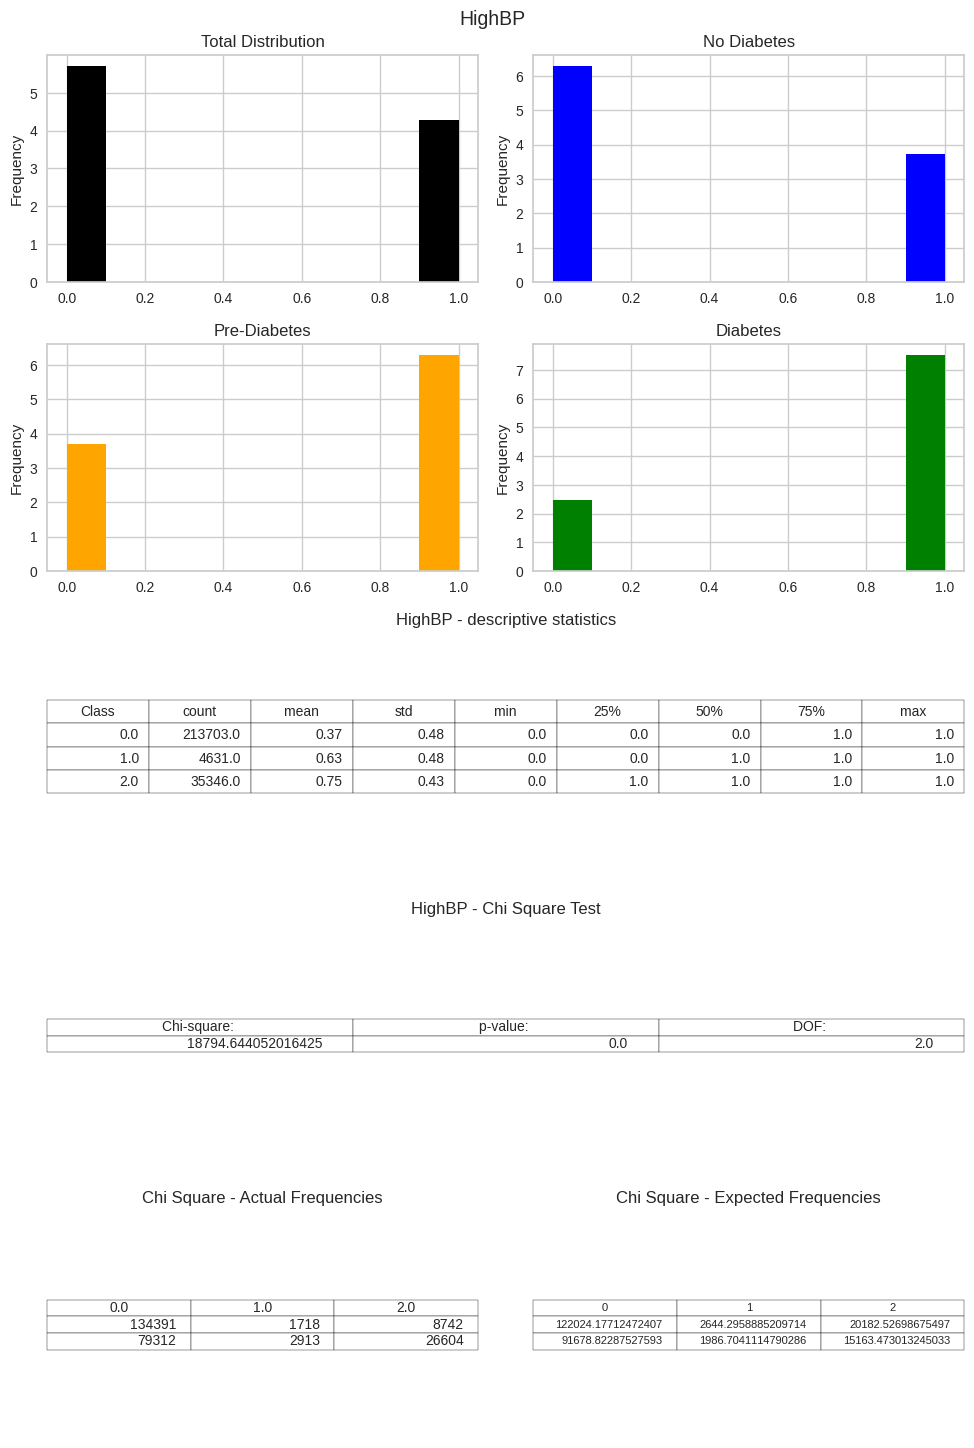

In [35]:
var = var_list[0]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### High Cholesterol

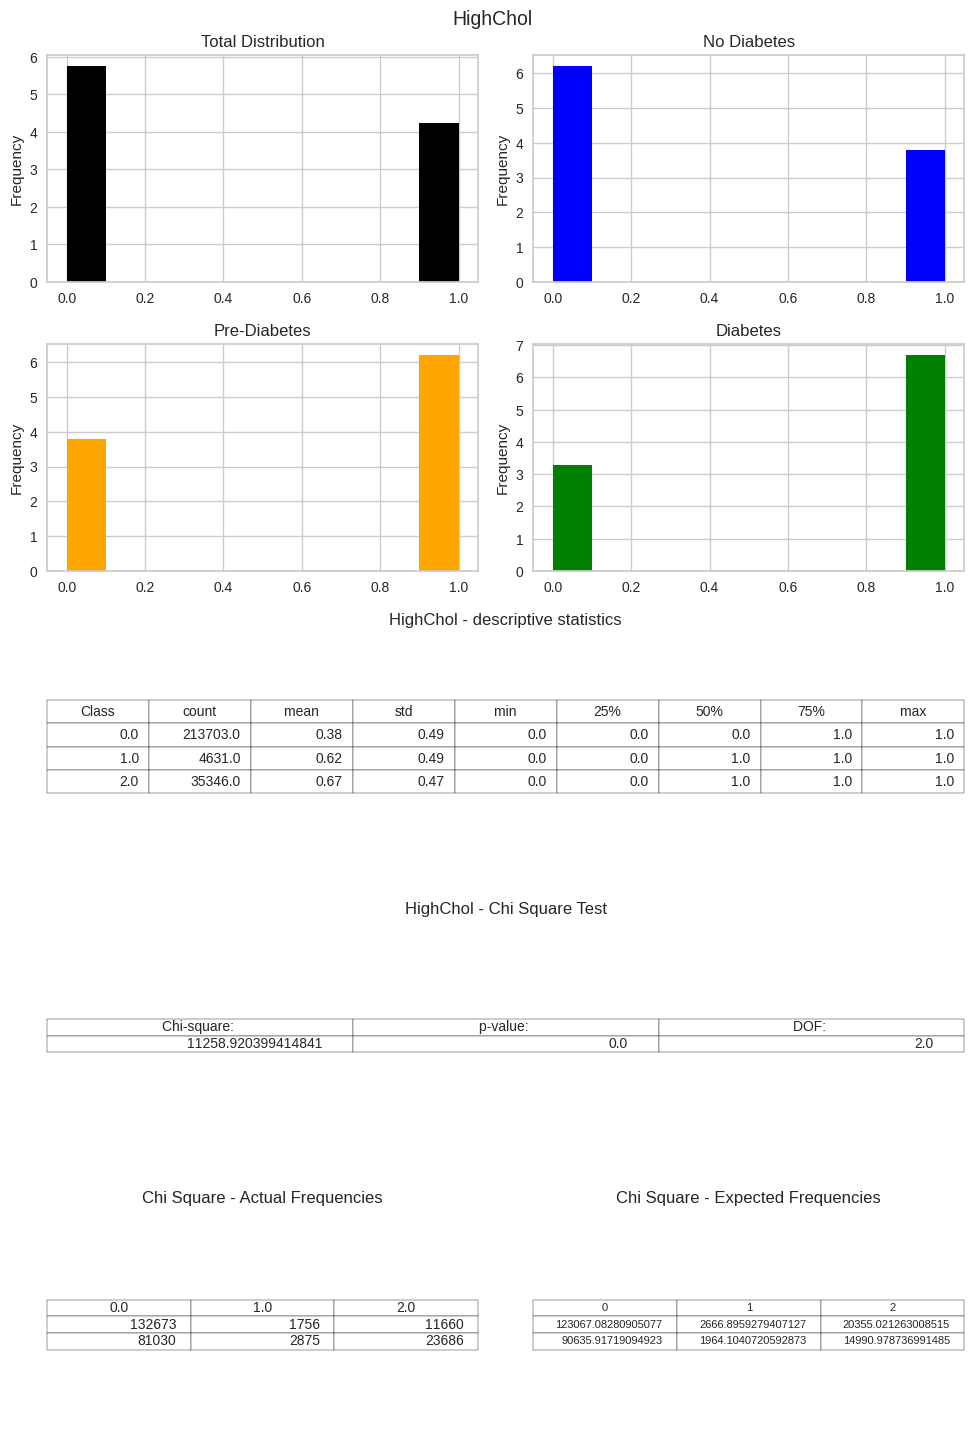

In [36]:
var = var_list[1]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Cholesterol Check

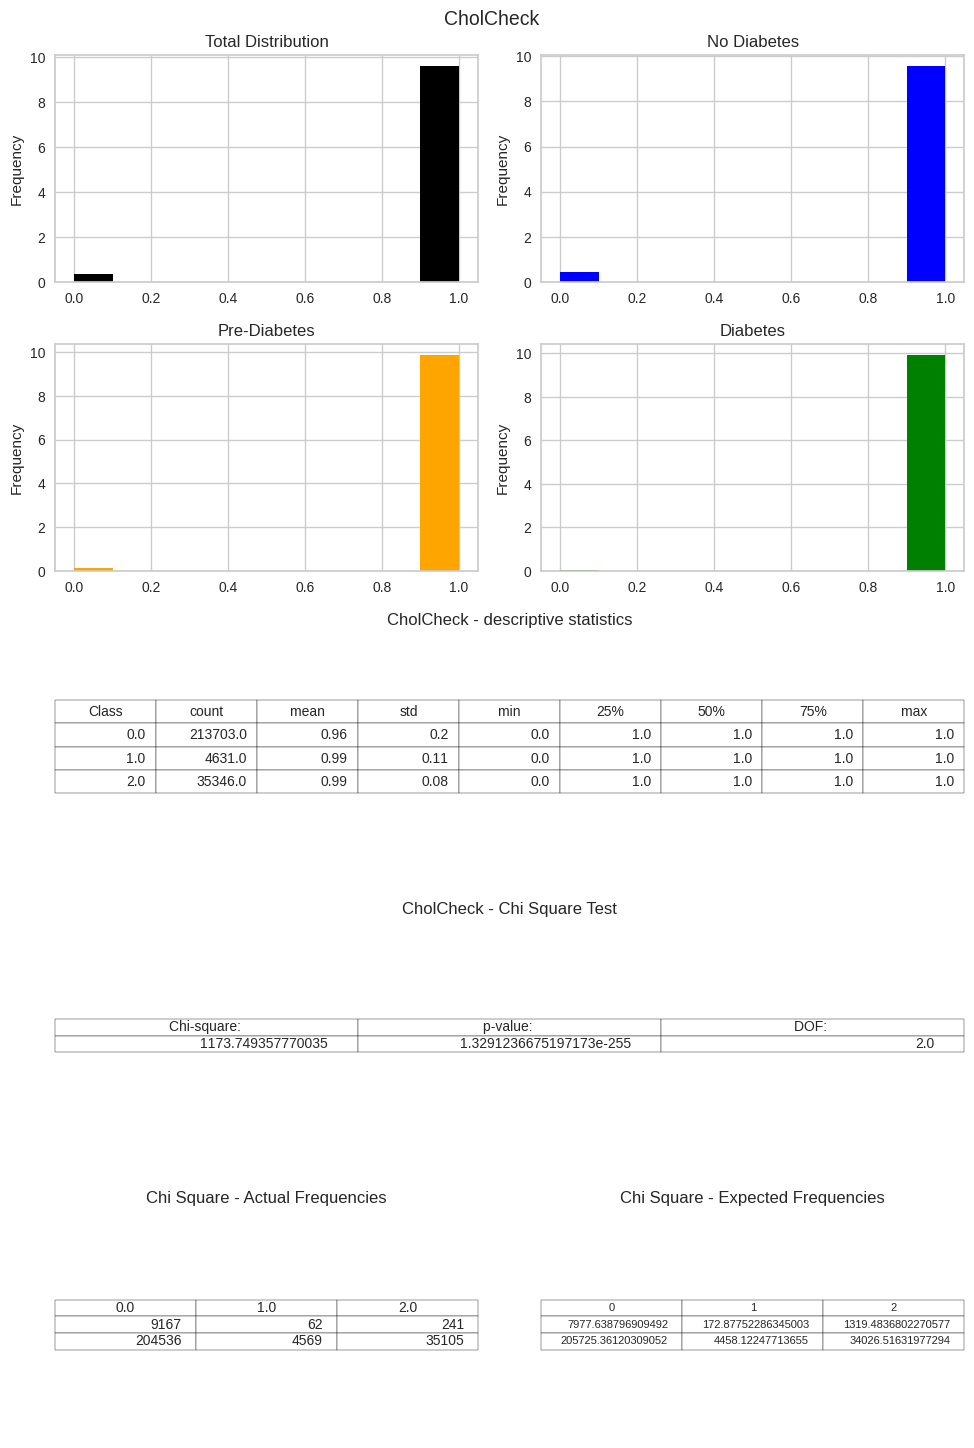

In [37]:
var = var_list[2]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### BMI

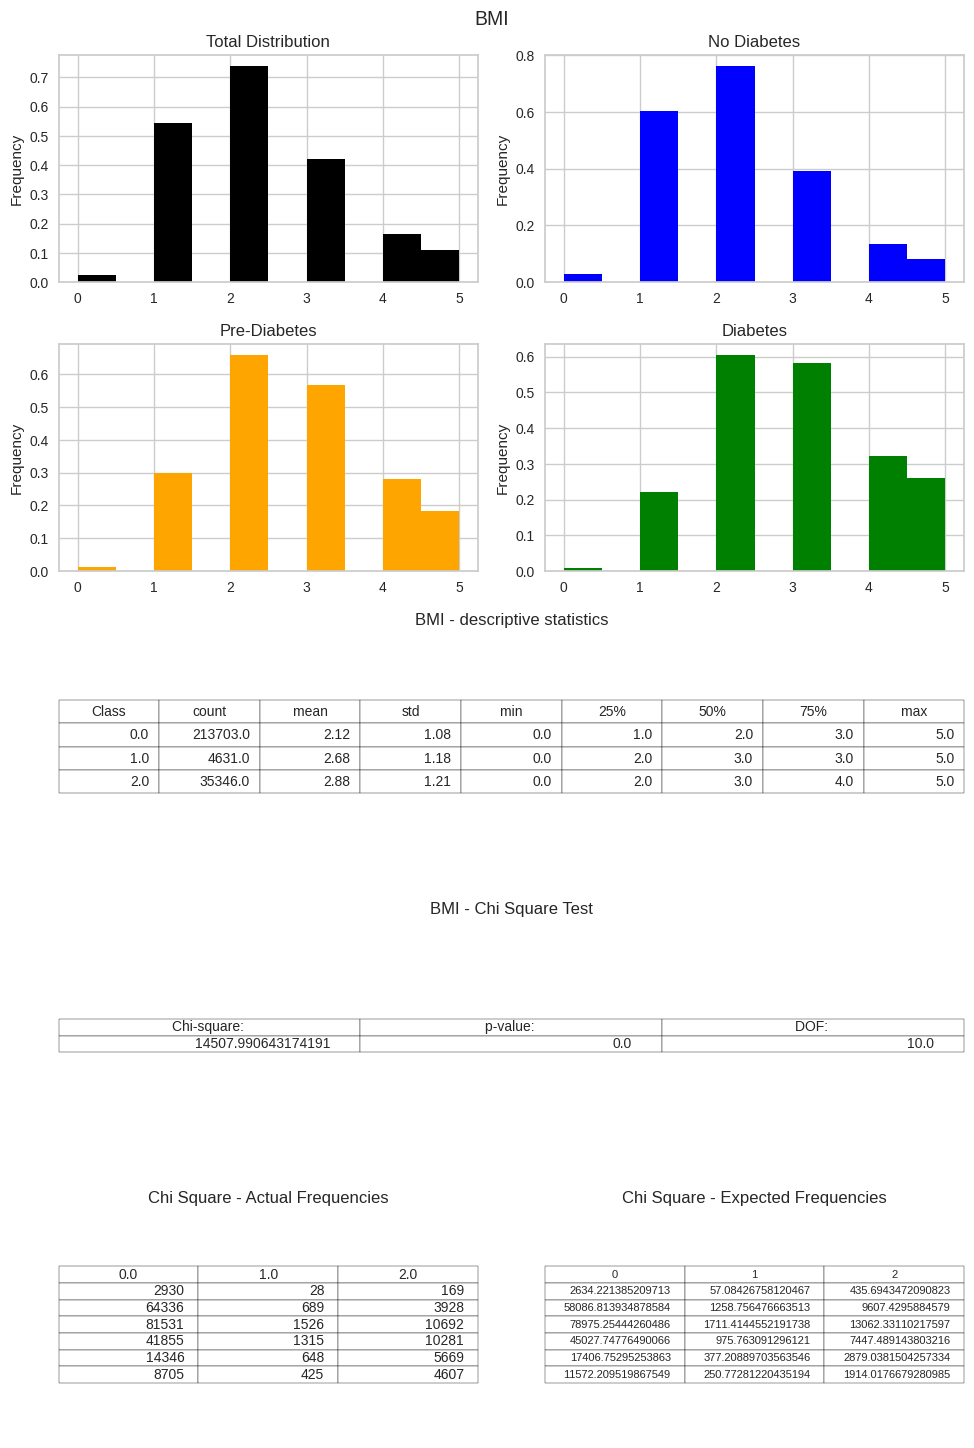

In [38]:
var = var_list[3]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Smoker

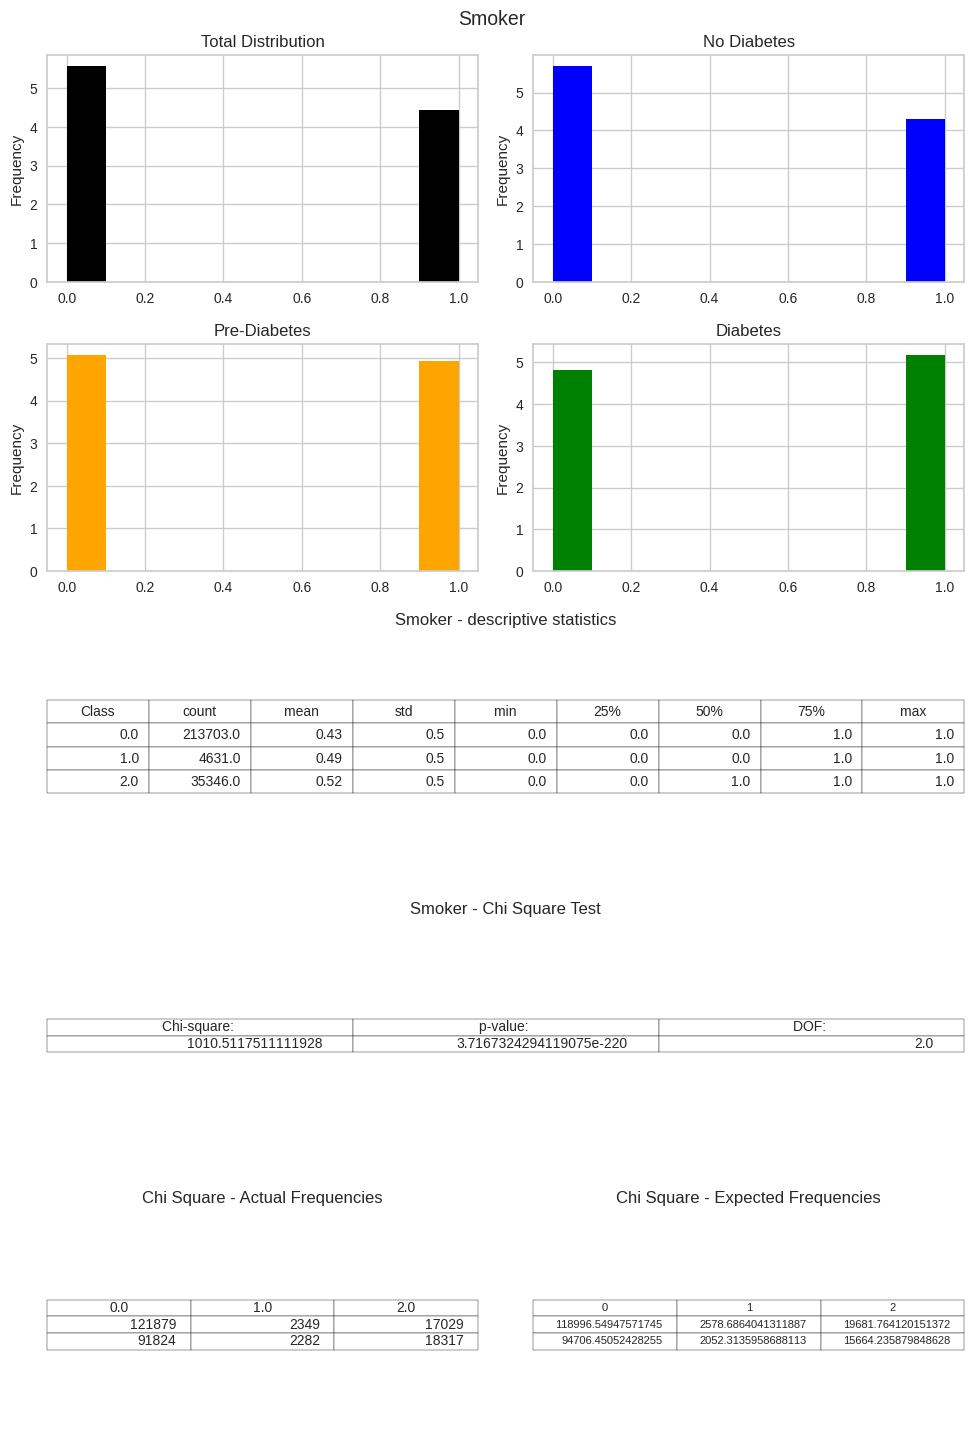

In [39]:
var = var_list[4]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Stroke

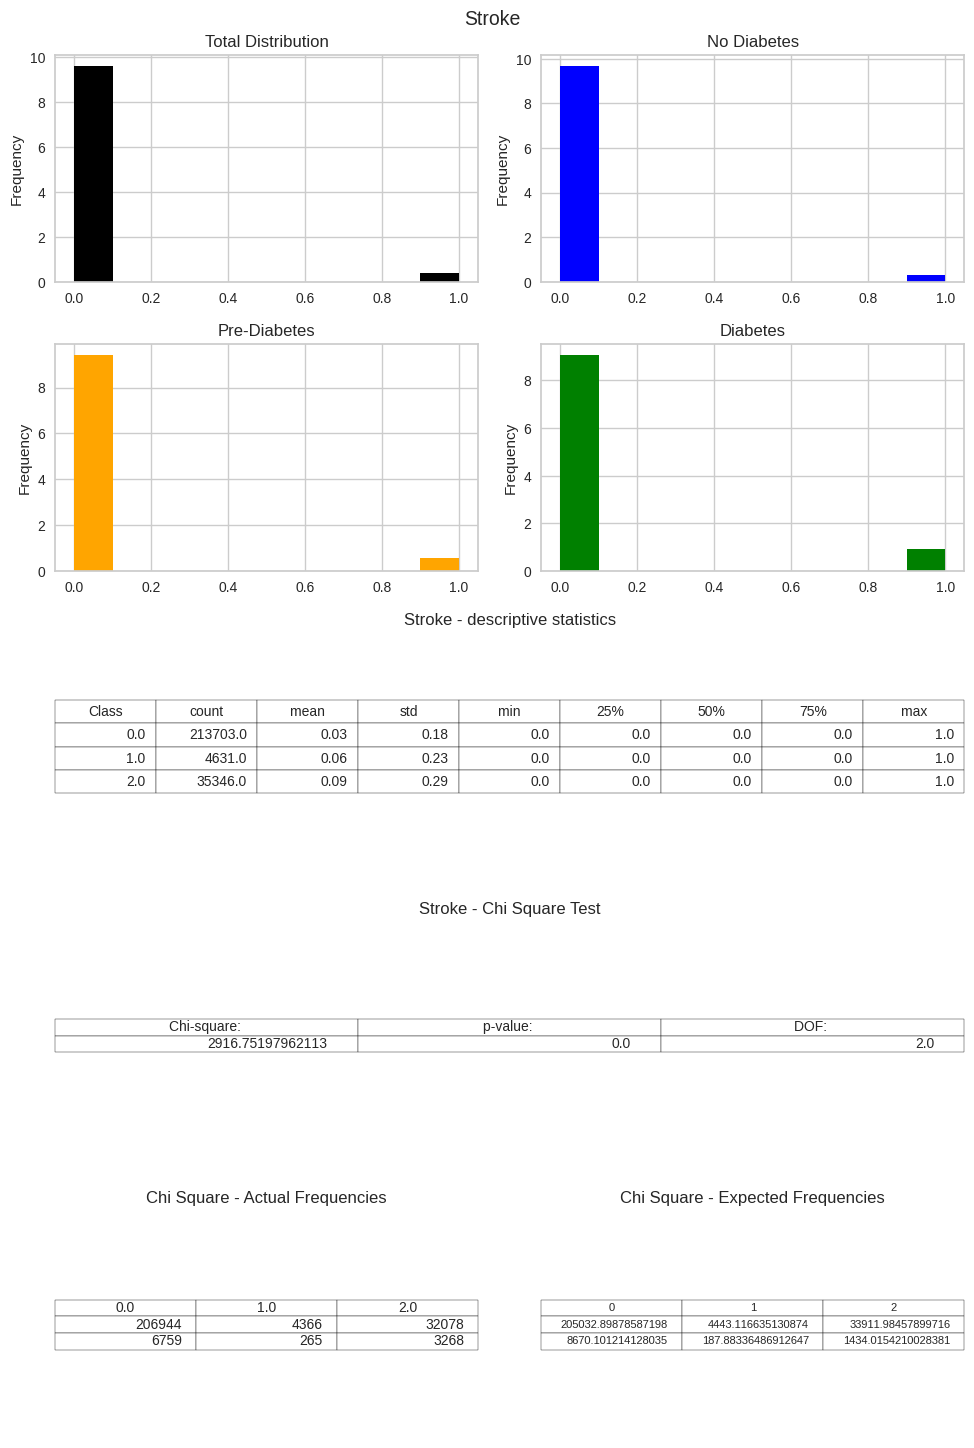

In [40]:
var = var_list[5]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Heart Disease or Attack

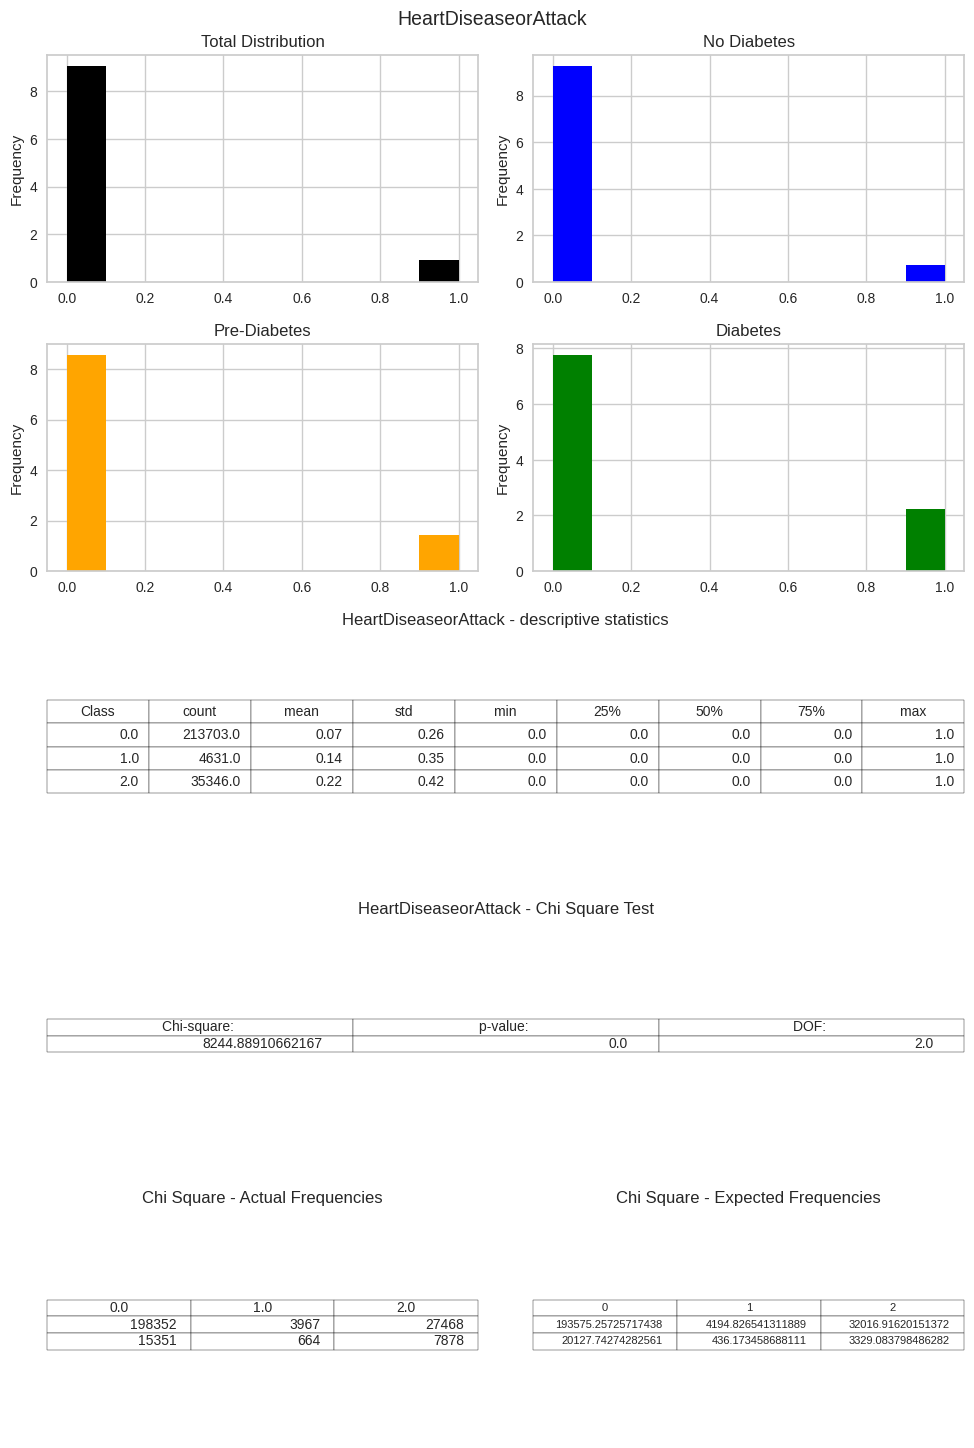

In [41]:
var = var_list[6]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Physical Activity

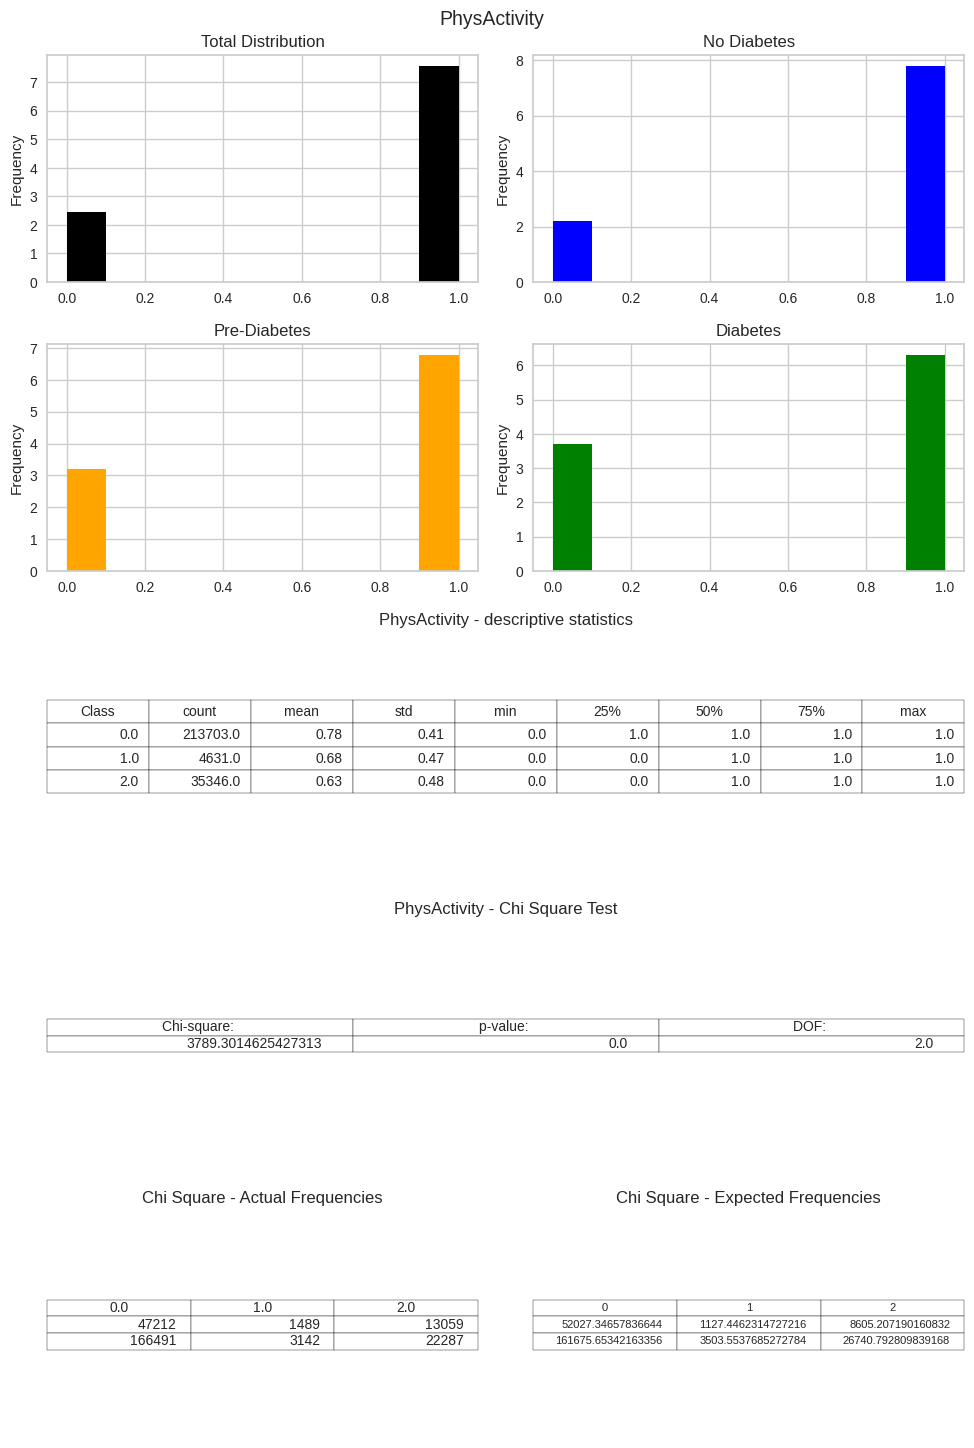

In [42]:
var = var_list[7]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Fruits

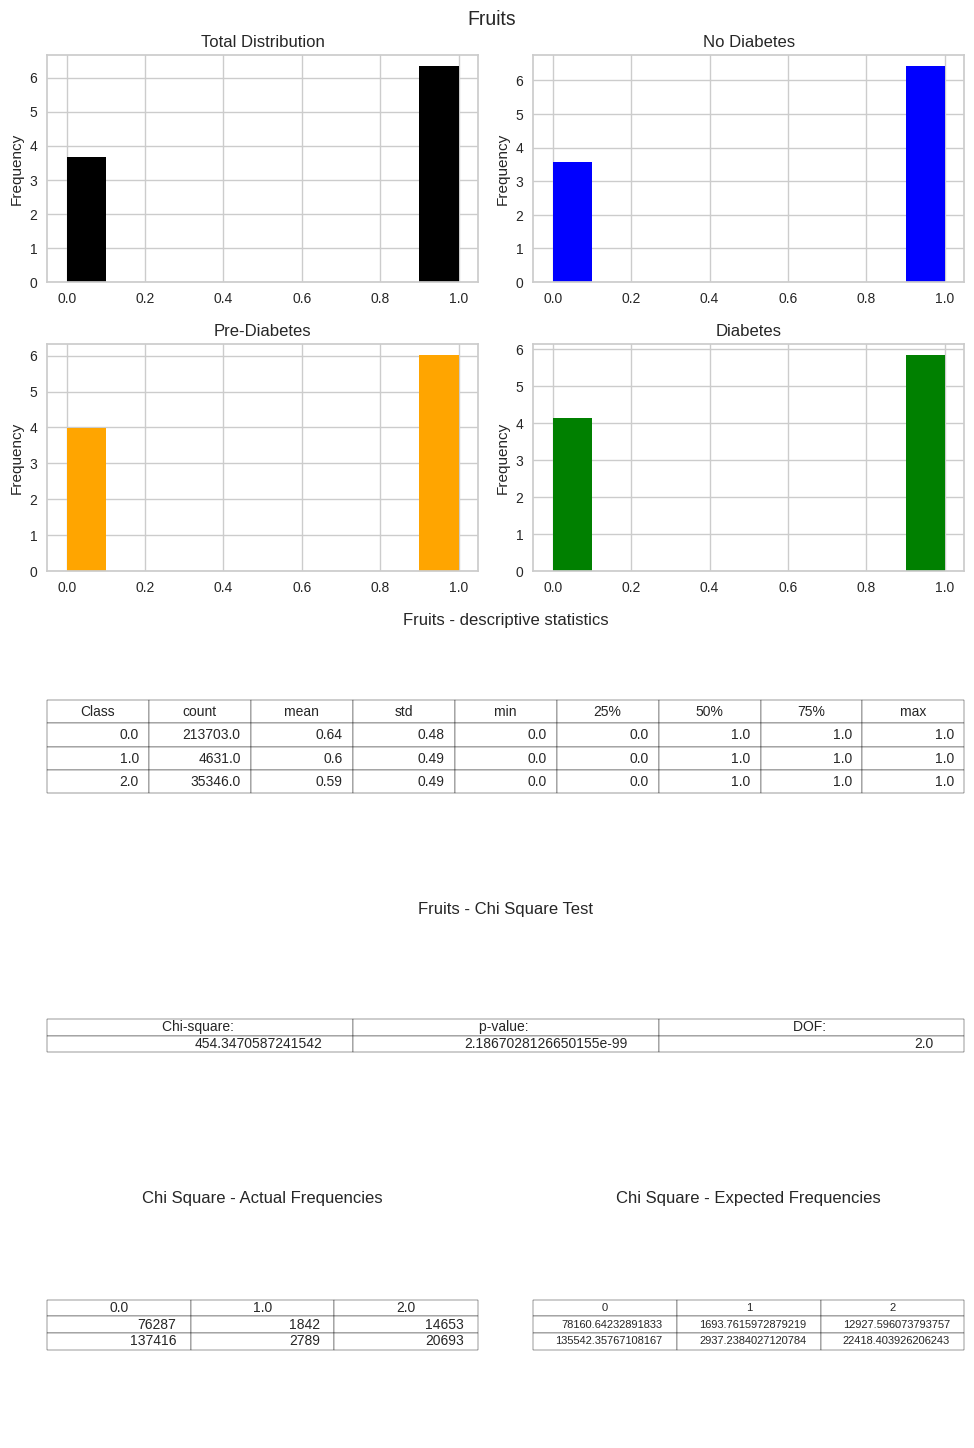

In [43]:
var = var_list[8]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Veggies

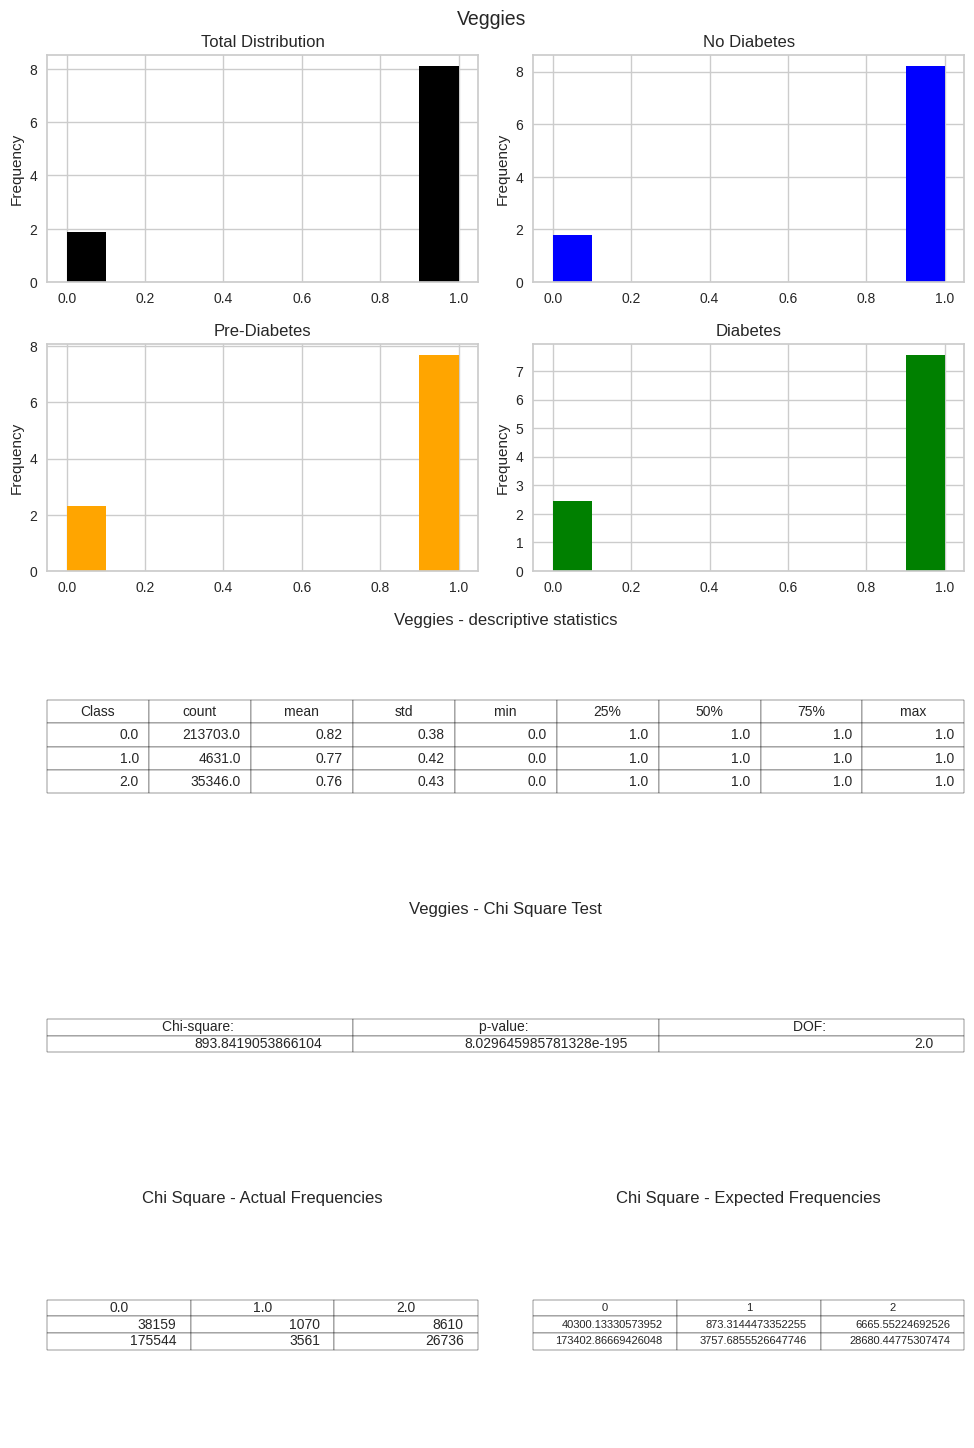

In [44]:
var = var_list[9]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Heavy Alcohol Consumption

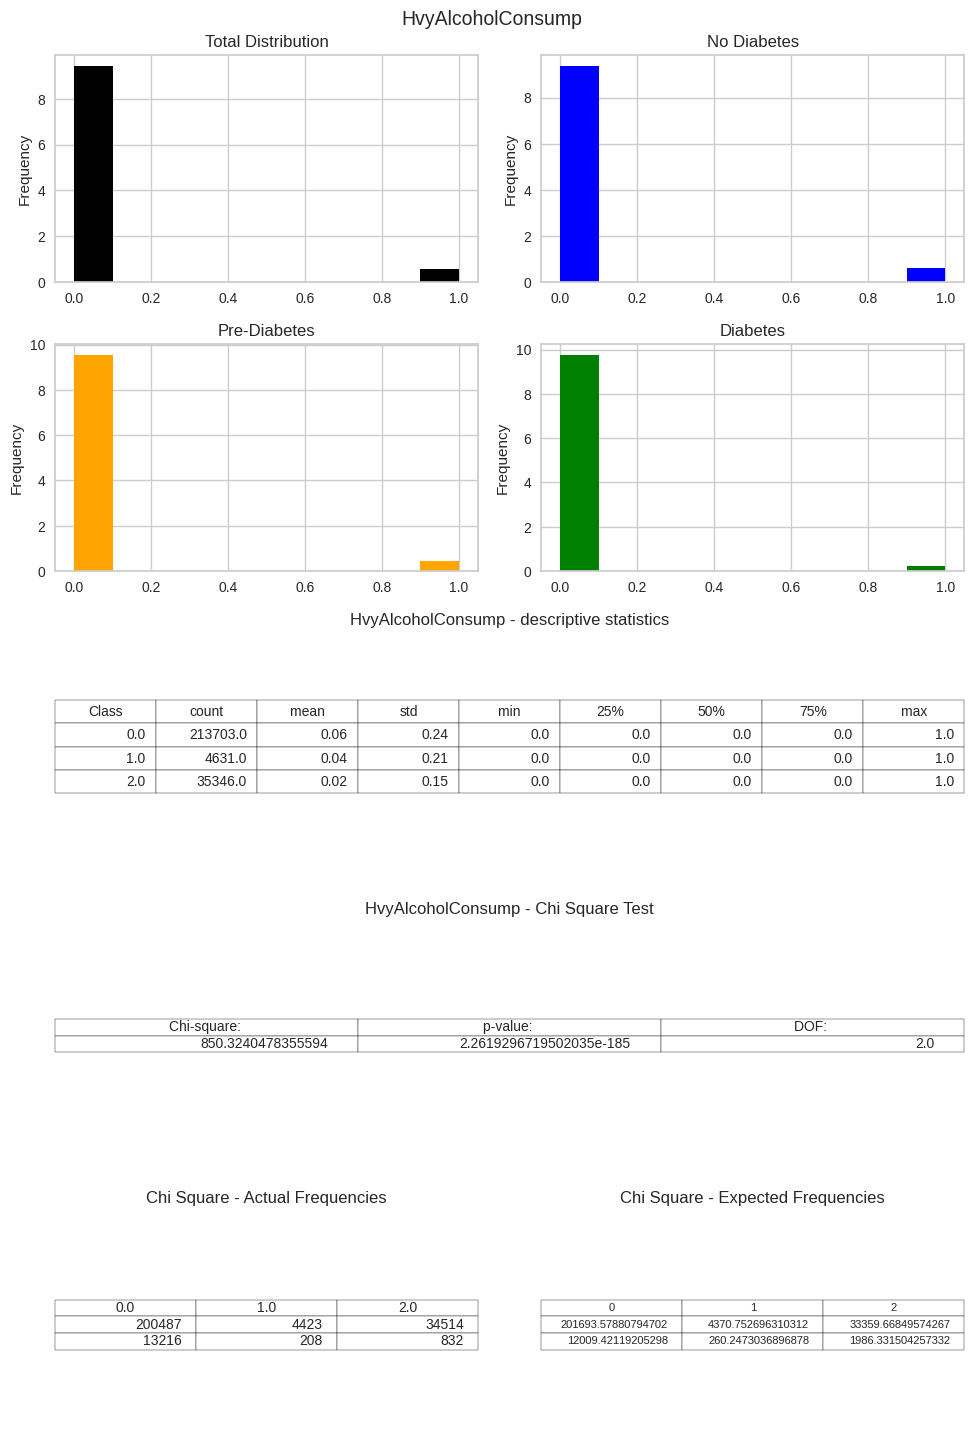

In [45]:
var = var_list[10]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### No Doctor Because of Cost

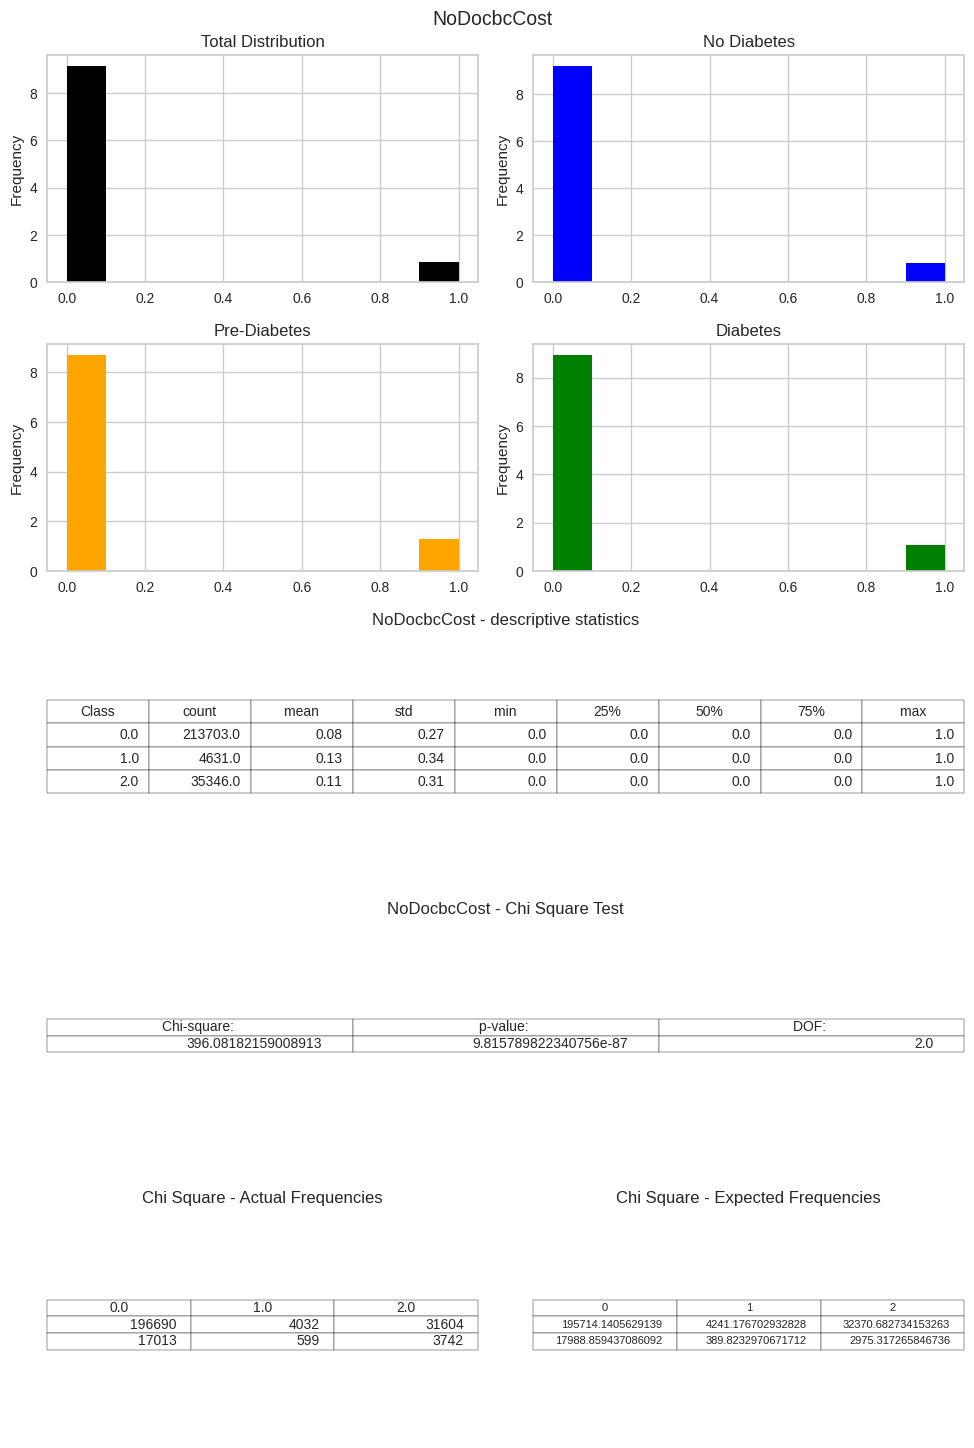

In [46]:
var = var_list[11]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### General Health

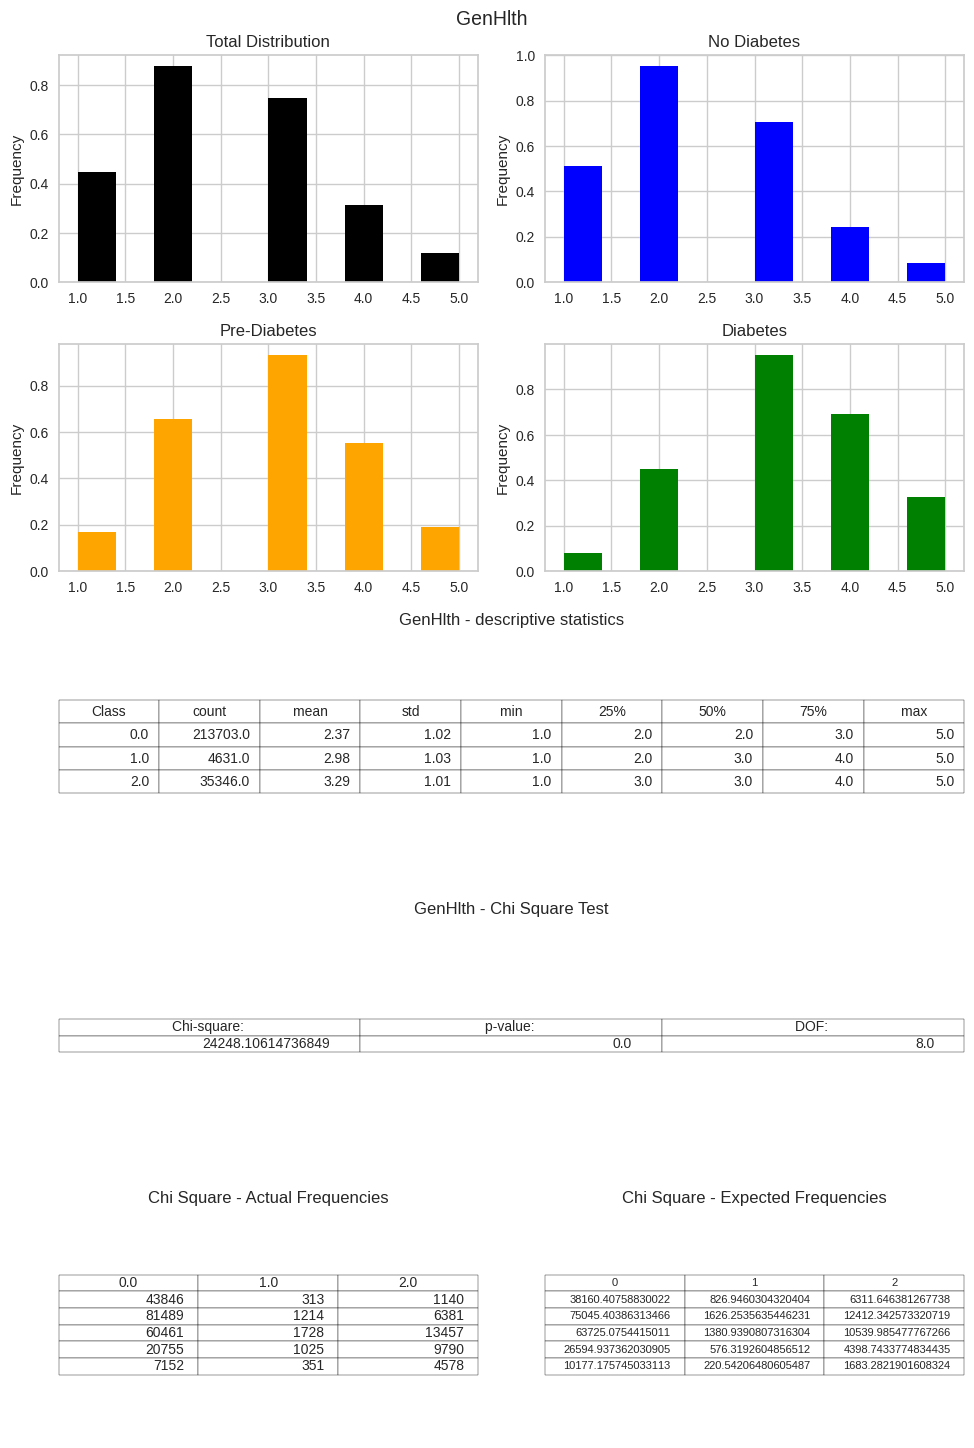

In [47]:
var = var_list[12]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Mental Health

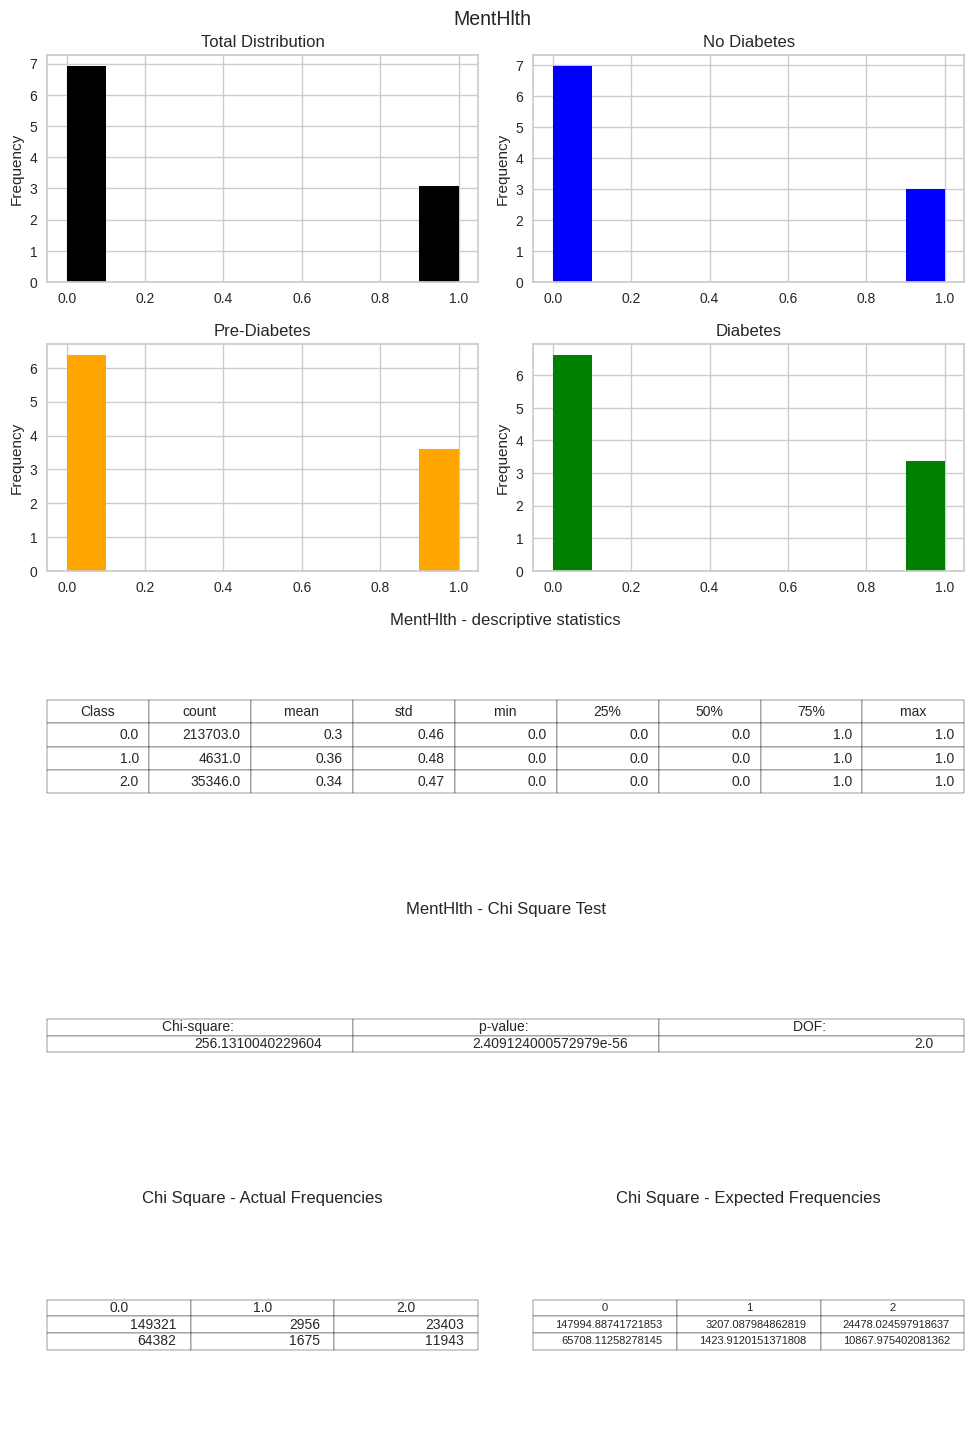

In [48]:
var = var_list[13]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Physical Health

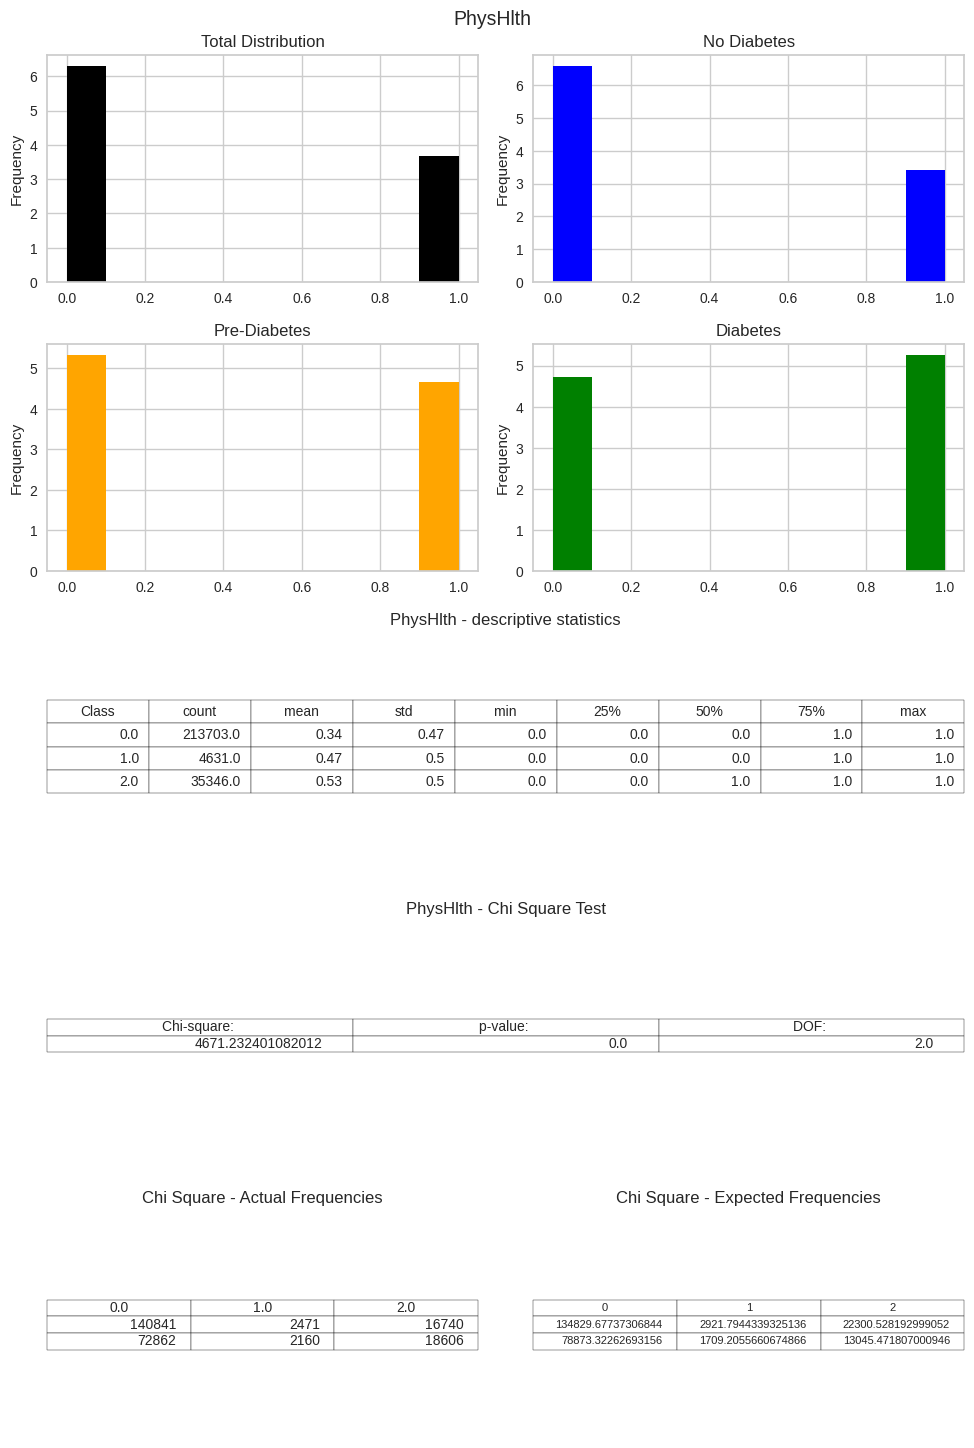

In [49]:
var = var_list[14]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Difficulty Walking

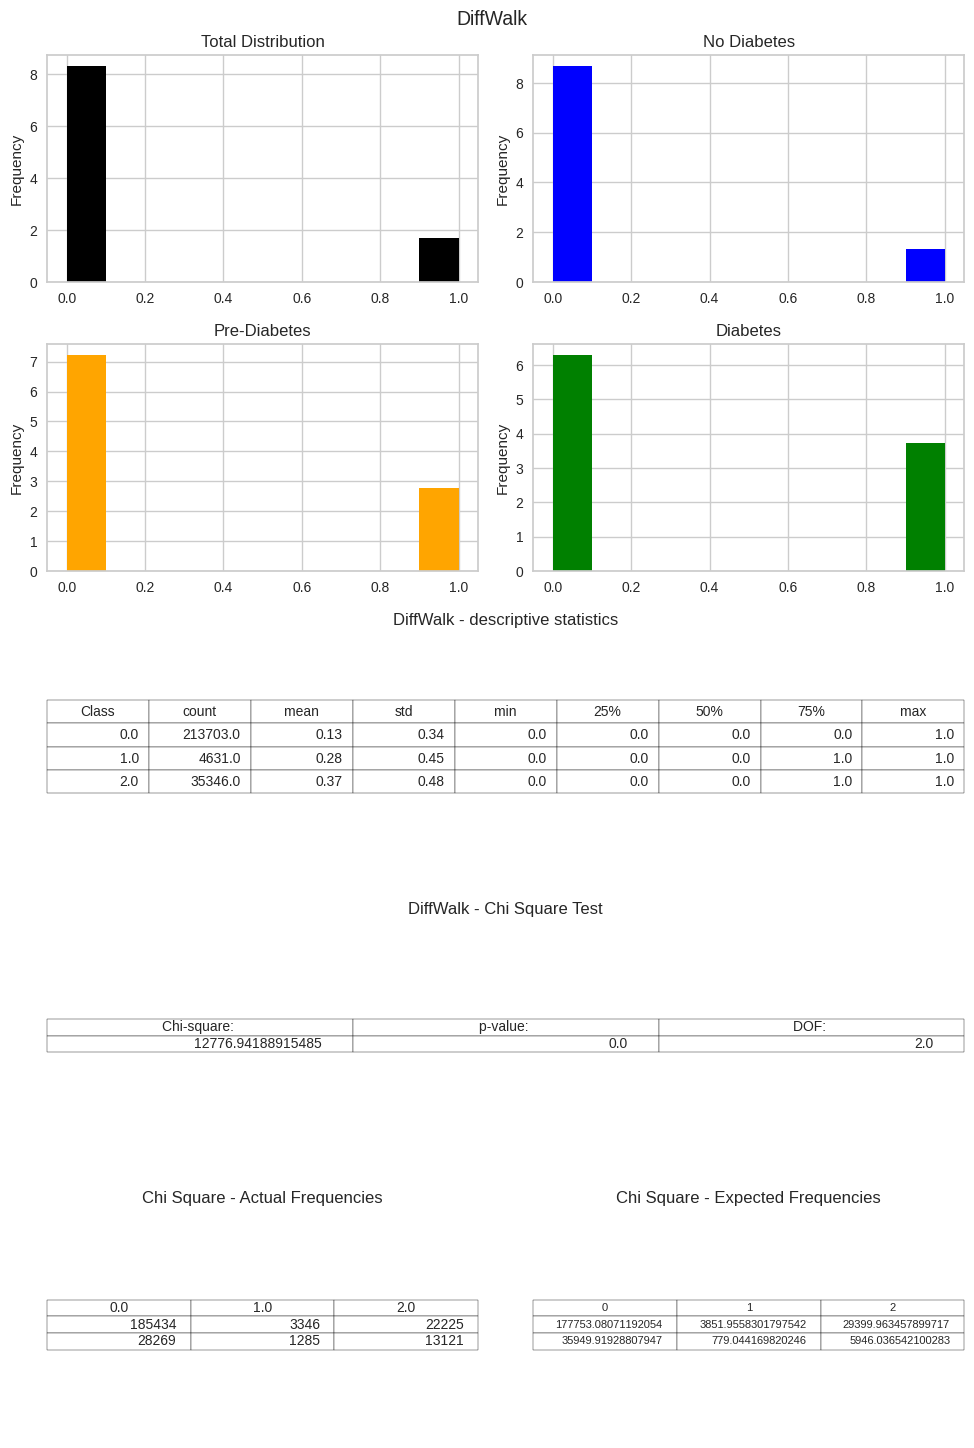

In [50]:
var = var_list[15]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Sex

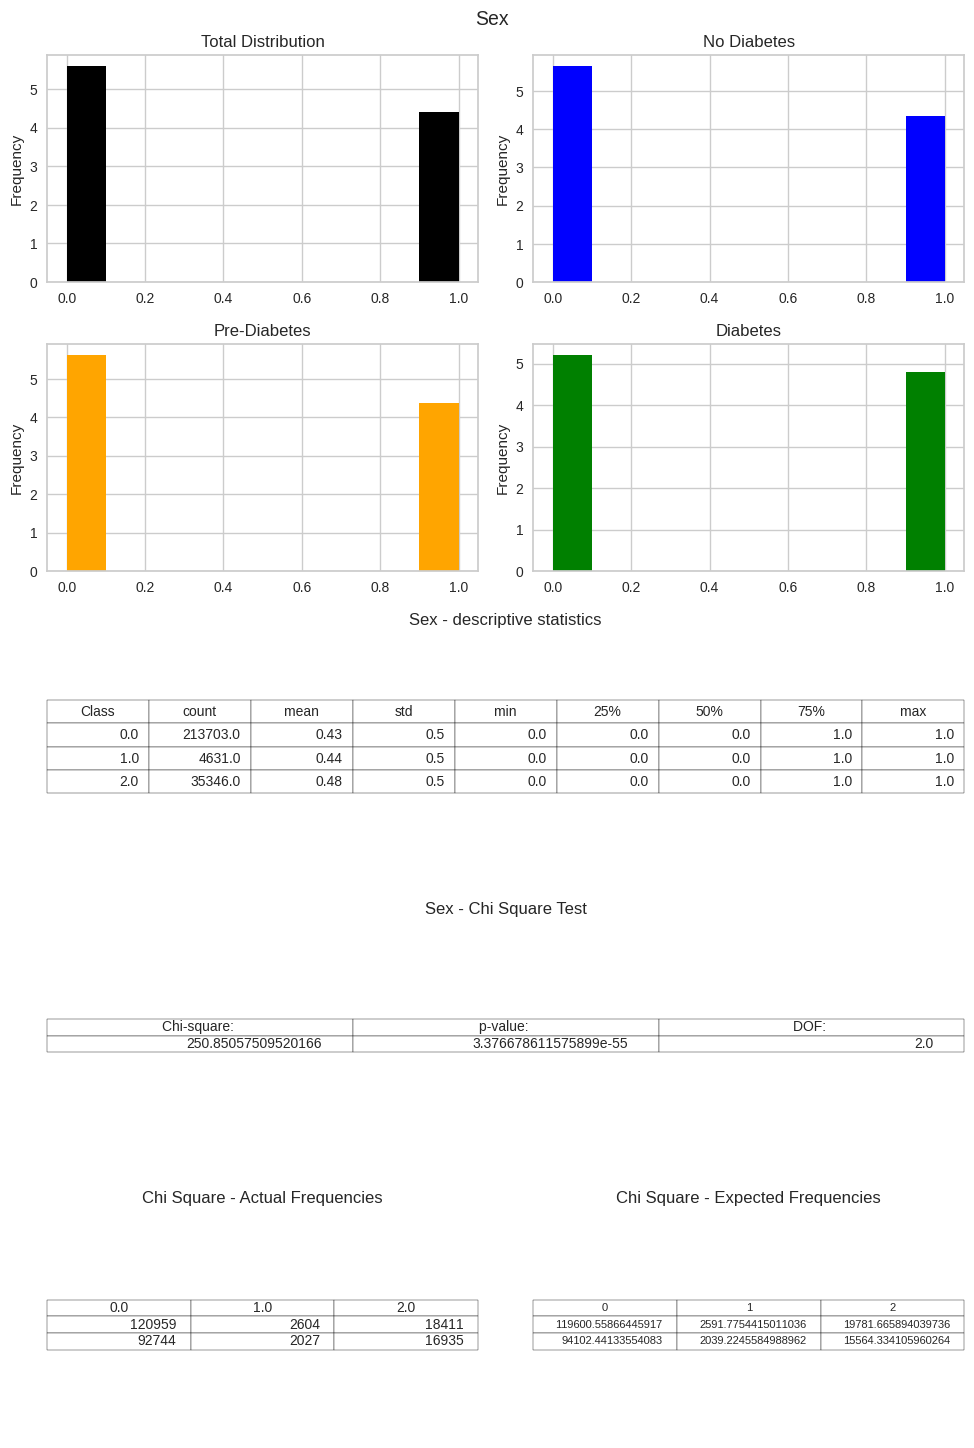

In [51]:
var = var_list[16]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Age Group

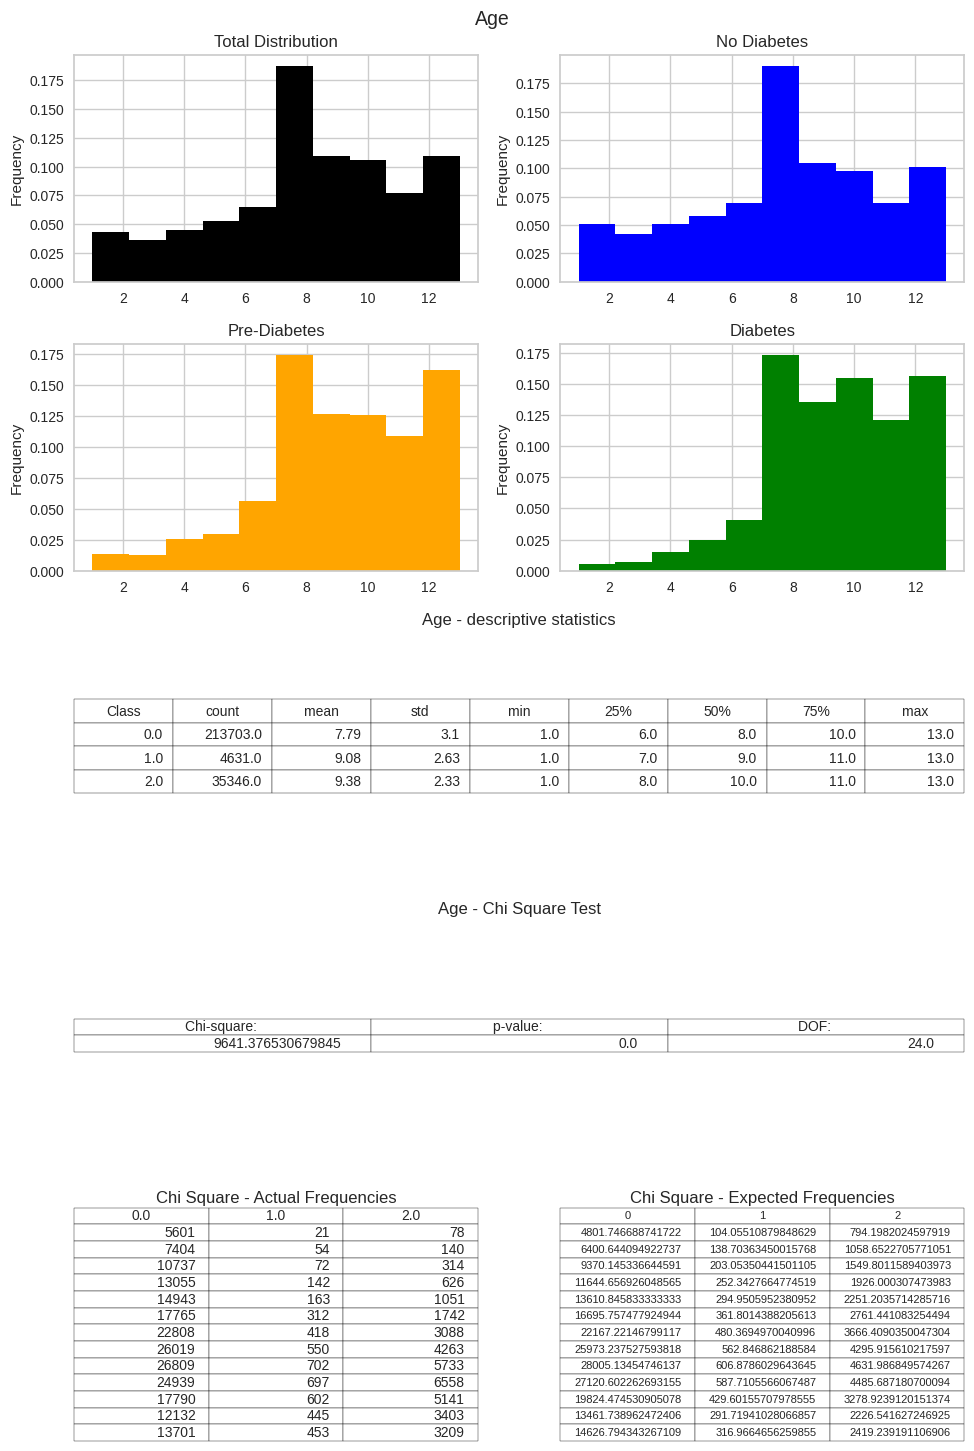

In [52]:
var = var_list[17]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Education

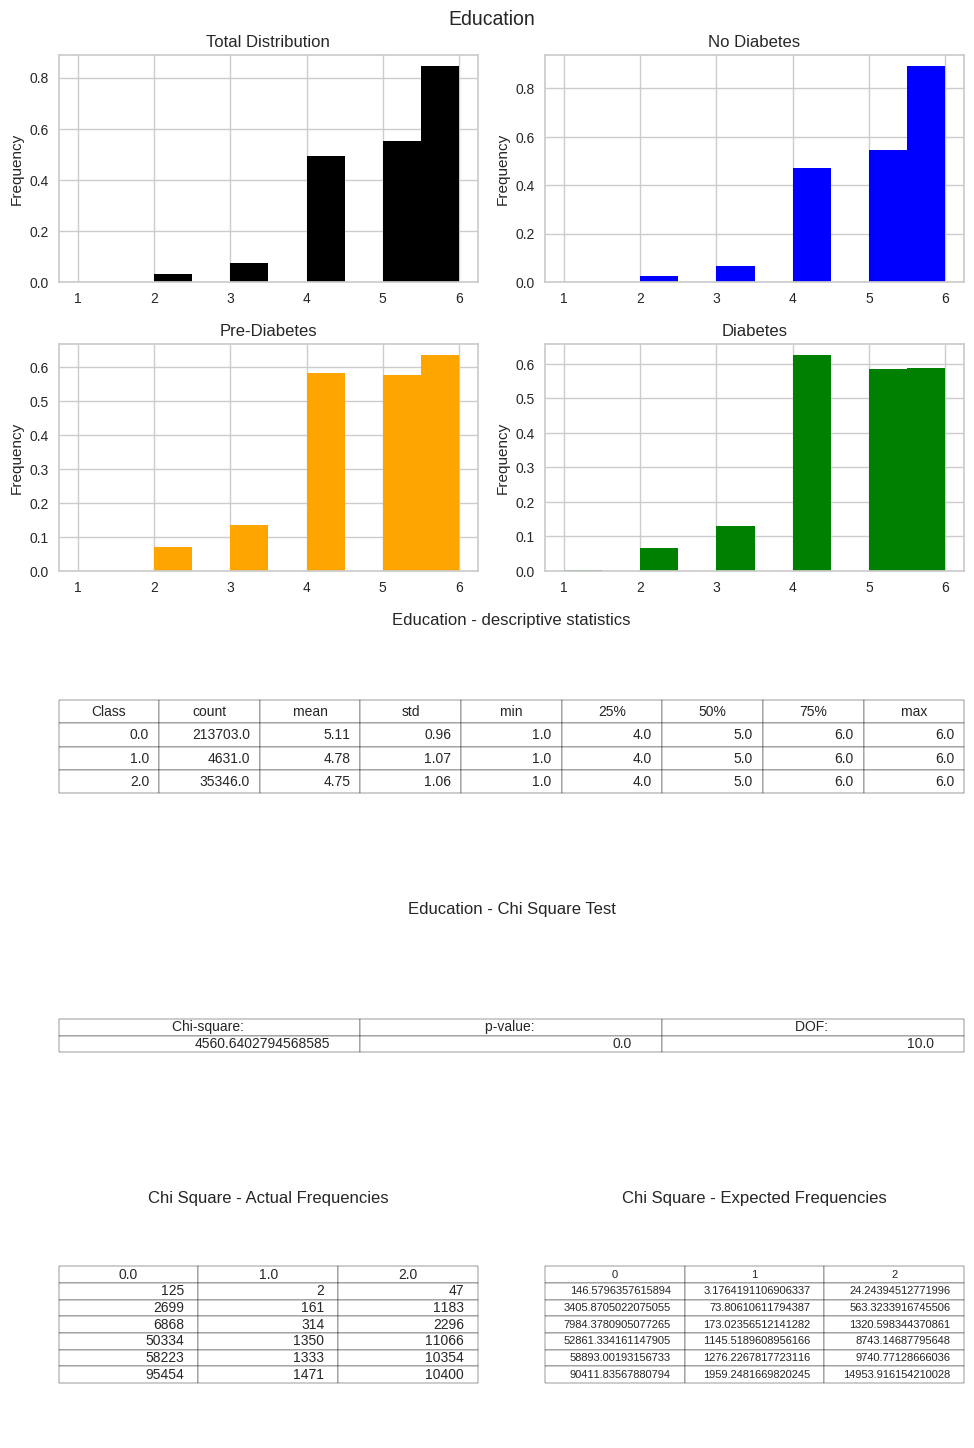

In [53]:
var = var_list[18]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Income

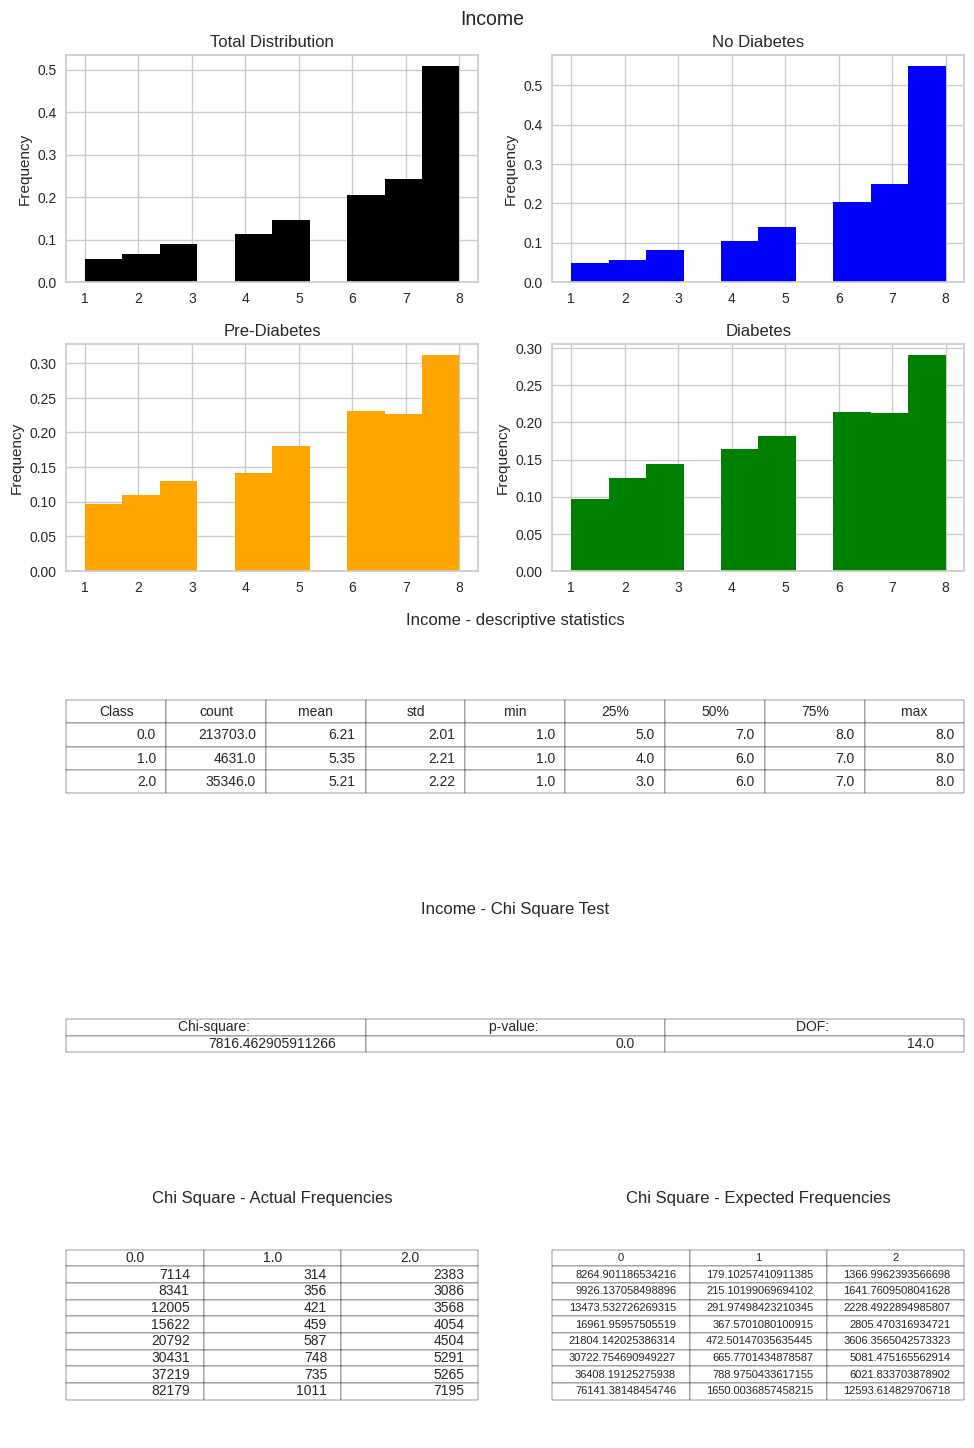

In [54]:
var = var_list[19]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

## Collinearity & Variance

When using regression techniques, we make the statistical assumption that are predictors are independent, or not related. Thus, it is important that we drop any strongly intercorrelated features from our analysis. 

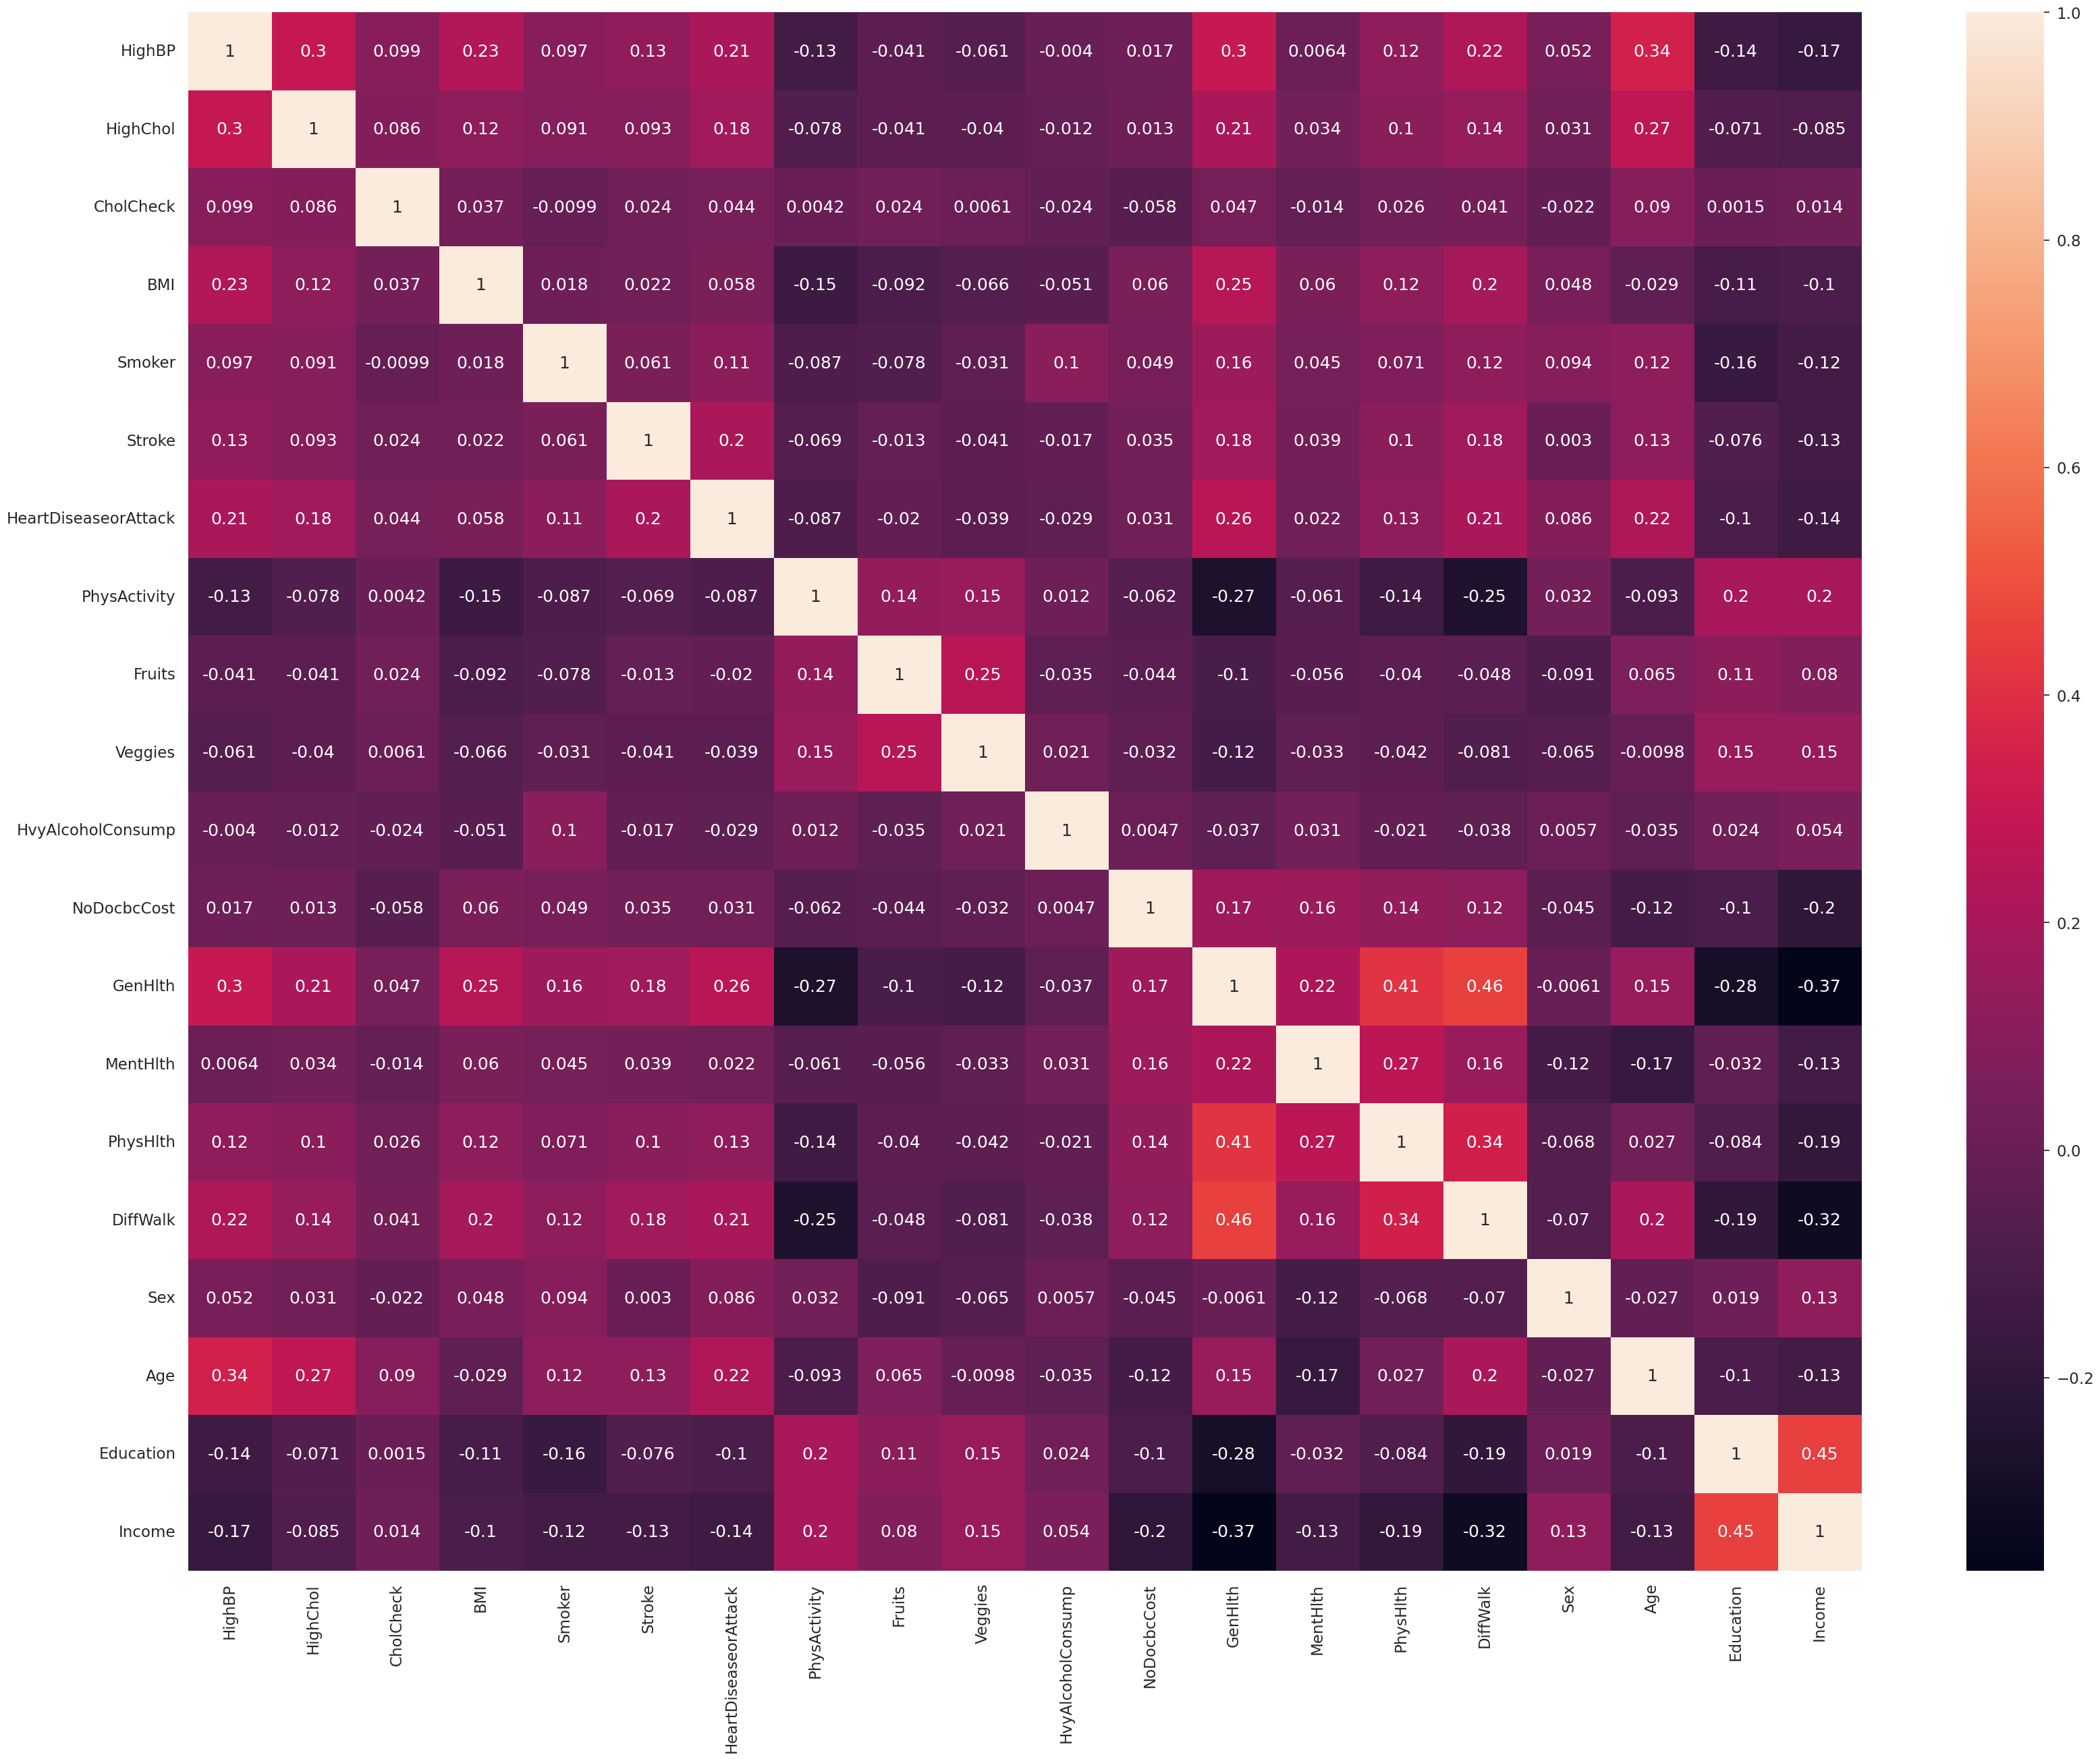

In [55]:
data_full = data
data_corr = data.drop(['Diabetes_012'],axis=1)
corrMatrix = data_corr.corr()
sn.set(rc={'figure.figsize':(40,30)})
sn.set(font_scale=1.5)
sn.heatmap(corrMatrix, annot=True)
plt.show()

We can see that there are actually not many values that are strongly intercorrelated. Usually a strong correlation is considered to be 0.70 or greater. However, there are some variables that are moderately intercorrelated.

In [56]:
data_corr = data.drop(['Diabetes_012'],axis=1)
vif = pd.DataFrame()
vif["features"] = data_corr.columns
vif["vif_Factor"] = [variance_inflation_factor(data_corr.values, i) for i in range(data_corr.shape[1])]
vif

features  vif_Factor
0                 HighBP    2.322786
1               HighChol    2.033875
2              CholCheck   20.722827
3                    BMI    5.346706
4                 Smoker    1.927276
5                 Stroke    1.126041
6   HeartDiseaseorAttack    1.287315
7           PhysActivity    4.615702
8                 Fruits    3.034288
9                Veggies    5.807982
10     HvyAlcoholConsump    1.084419
11           NoDocbcCost    1.181993
12               GenHlth    9.805601
13              MentHlth    1.688450
14              PhysHlth    2.067739
15              DiffWalk    1.736705
16                   Sex    1.925830
17                   Age    9.711543
18             Education   27.074390
19                Income   13.692790

We will drop variables one by one, starting with the highest VIF scores.

In [57]:
data = data.drop(columns=['Education'])

In [58]:
data_corr = data.drop(['Diabetes_012'],axis=1)
vif = pd.DataFrame()
vif["features"] = data_corr.columns
vif["vif_Factor"] = [variance_inflation_factor(data_corr.values, i) for i in range(data_corr.shape[1])]
vif

features  vif_Factor
0                 HighBP    2.311882
1               HighChol    2.032887
2              CholCheck   18.457756
3                    BMI    5.298385
4                 Smoker    1.924153
5                 Stroke    1.126039
6   HeartDiseaseorAttack    1.285671
7           PhysActivity    4.452646
8                 Fruits    3.016895
9                Veggies    5.680700
10     HvyAlcoholConsump    1.083820
11           NoDocbcCost    1.176998
12               GenHlth    9.731585
13              MentHlth    1.671813
14              PhysHlth    2.065178
15              DiffWalk    1.736324
16                   Sex    1.922664
17                   Age    9.421082
18                Income    9.985620

In [59]:
data = data.drop(columns=['CholCheck'])

In [60]:
data_corr = data.drop(['Diabetes_012'],axis=1)
vif = pd.DataFrame()
vif["features"] = data_corr.columns
vif["vif_Factor"] = [variance_inflation_factor(data_corr.values, i) for i in range(data_corr.shape[1])]
vif

features  vif_Factor
0                 HighBP    2.311745
1               HighChol    2.032392
2                    BMI    5.092232
3                 Smoker    1.921219
4                 Stroke    1.126029
5   HeartDiseaseorAttack    1.283788
6           PhysActivity    4.287977
7                 Fruits    2.998835
8                Veggies    5.585239
9      HvyAlcoholConsump    1.083805
10           NoDocbcCost    1.175458
11               GenHlth    8.956508
12              MentHlth    1.661316
13              PhysHlth    2.065152
14              DiffWalk    1.735928
15                   Sex    1.921194
16                   Age    8.489899
17                Income    8.495059

In [61]:
data = data.drop(columns=['GenHlth'])

In [62]:
data_corr = data.drop(['Diabetes_012'],axis=1)
vif = pd.DataFrame()
vif["features"] = data_corr.columns
vif["vif_Factor"] = [variance_inflation_factor(data_corr.values, i) for i in range(data_corr.shape[1])]
vif

features  vif_Factor
0                 HighBP    2.292238
1               HighChol    2.026347
2                    BMI    4.628743
3                 Smoker    1.893920
4                 Stroke    1.122501
5   HeartDiseaseorAttack    1.274740
6           PhysActivity    4.284849
7                 Fruits    2.997366
8                Veggies    5.553751
9      HvyAlcoholConsump    1.083792
10           NoDocbcCost    1.155482
11              MentHlth    1.606272
12              PhysHlth    1.908024
13              DiffWalk    1.653830
14                   Sex    1.906838
15                   Age    7.863807
16                Income    8.452665

In [63]:
data = data.drop(columns=['Income'])

In [64]:
data_corr = data.drop(['Diabetes_012'],axis=1)
vif = pd.DataFrame()
vif["features"] = data_corr.columns
vif["vif_Factor"] = [variance_inflation_factor(data_corr.values, i) for i in range(data_corr.shape[1])]
vif

features  vif_Factor
0                 HighBP    2.265576
1               HighChol    2.026163
2                    BMI    4.301284
3                 Smoker    1.893884
4                 Stroke    1.120491
5   HeartDiseaseorAttack    1.266492
6           PhysActivity    3.922077
7                 Fruits    2.964101
8                Veggies    5.100001
9      HvyAlcoholConsump    1.077011
10           NoDocbcCost    1.147993
11              MentHlth    1.595570
12              PhysHlth    1.906550
13              DiffWalk    1.603319
14                   Sex    1.807302
15                   Age    7.119950

In [65]:
data = data.drop(columns=['Age'])

In [66]:
data_corr = data.drop(['Diabetes_012'],axis=1)
vif = pd.DataFrame()
vif["features"] = data_corr.columns
vif["vif_Factor"] = [variance_inflation_factor(data_corr.values, i) for i in range(data_corr.shape[1])]
vif

features  vif_Factor
0                 HighBP    2.110614
1               HighChol    1.928457
2                    BMI    4.142007
3                 Smoker    1.827928
4                 Stroke    1.117481
5   HeartDiseaseorAttack    1.255928
6           PhysActivity    3.689468
7                 Fruits    2.843776
8                Veggies    4.753315
9      HvyAlcoholConsump    1.076948
10           NoDocbcCost    1.140417
11              MentHlth    1.585389
12              PhysHlth    1.902038
13              DiffWalk    1.569613
14                   Sex    1.798843

In [67]:
data_corr = data.drop(['Diabetes_012'],axis=1)
corrMatrix = data_corr.corr()
sn.set(rc={'figure.figsize':(40,30)})
sn.set(font_scale=1.5)
sn.heatmap(corrMatrix, annot=True)
plt.show()

We can see that there are still features that are moderately correlated. We will eliminate one of the features for each correlated pair to reduce collinearity. 

## Create training and testing data sets

In [68]:
y = data['Diabetes_012']
x = data.drop('Diabetes_012',axis=1)
print('Available Features',x.columns)
from sklearn.model_selection import train_test_split
x_tr_1, x_tst_1, y_tr_1, y_tst_1 = train_test_split(x,y,test_size = 0.25, shuffle=True, stratify=y, random_state=0)

Available Features Index(['HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
       'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'NoDocbcCost',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex'],
      dtype='object')


## Initial Multinomial Logistic Regression Models

### Statsmodels 

In [70]:
from statsmodels.discrete.discrete_model import MNLogit
from statsmodels.tools import add_constant
x_tr_1_const = add_constant(x_tr_1)
print(MNLogit(y_tr_1, x_tr_1_const).fit().summary())

Optimization terminated successfully.
         Current function value: 0.416463
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:           Diabetes_012   No. Observations:               190260
Model:                        MNLogit   Df Residuals:                   190228
Method:                           MLE   Df Model:                           30
Date:                Sun, 23 Jul 2023   Pseudo R-squ.:                  0.1538
Time:                        17:03:55   Log-Likelihood:                -79236.
converged:                       True   LL-Null:                       -93637.
Covariance Type:            nonrobust   LLR p-value:                     0.000
      Diabetes_012=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -5.2789      0.074    -71.528      0.000      -5.424      -5.134

We can see that our model is doing an ok job, but could be improved. 
Let's start by removing variables that are not statistically significant for either diabetes and pre-diabetes. 

In [71]:
x_tr_1_const_2 = x_tr_1_const.drop(columns=['NoDocbcCost','Fruits','Sex','MentHlth','Stroke'])
model = MNLogit(y_tr_1, x_tr_1_const_2).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.417350
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:           Diabetes_012   No. Observations:               190260
Model:                        MNLogit   Df Residuals:                   190238
Method:                           MLE   Df Model:                           20
Date:                Sun, 23 Jul 2023   Pseudo R-squ.:                  0.1520
Time:                        17:04:05   Log-Likelihood:                -79405.
converged:                       True   LL-Null:                       -93637.
Covariance Type:            nonrobust   LLR p-value:                     0.000
      Diabetes_012=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -5.2522      0.070    -75.456      0.000      -5.389      -5.116

It's still performing about the same. We can try another set of samples and see how it does.

In [72]:
x_tr_2, x_tst_2, y_tr_2, y_tst_2 = train_test_split(x,y,test_size = 0.25, shuffle=True, stratify=y, random_state=1)
x_tr_2_const = add_constant(x_tr_2)
print(MNLogit(y_tr_2, x_tr_2_const).fit().summary())

Optimization terminated successfully.
         Current function value: 0.416637
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:           Diabetes_012   No. Observations:               190260
Model:                        MNLogit   Df Residuals:                   190228
Method:                           MLE   Df Model:                           30
Date:                Sun, 23 Jul 2023   Pseudo R-squ.:                  0.1534
Time:                        17:04:20   Log-Likelihood:                -79269.
converged:                       True   LL-Null:                       -93637.
Covariance Type:            nonrobust   LLR p-value:                     0.000
      Diabetes_012=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -5.2260      0.073    -71.168      0.000      -5.370      -5.082

In [73]:
x_tr_2_const_2 = x_tr_2_const.drop(columns=['NoDocbcCost','Fruits','Sex','MentHlth','Fruits','Stroke'])
model = MNLogit(y_tr_2, x_tr_2_const_2).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.417595
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:           Diabetes_012   No. Observations:               190260
Model:                        MNLogit   Df Residuals:                   190238
Method:                           MLE   Df Model:                           20
Date:                Sun, 23 Jul 2023   Pseudo R-squ.:                  0.1515
Time:                        17:04:25   Log-Likelihood:                -79452.
converged:                       True   LL-Null:                       -93637.
Covariance Type:            nonrobust   LLR p-value:                     0.000
      Diabetes_012=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -5.2034      0.069    -75.174      0.000      -5.339      -5.068

Both models are performing about the same. We can see that we're routinely dropping a certain set of variables. 
Let's drop them from our overall dataset before trying some additional model types. 

'NoDocbcCost','Fruits','Sex','MentHlth','Fruits','Stroke'


In [74]:
data = data.drop(columns=['NoDocbcCost','Fruits','Sex','MentHlth','Fruits','Stroke'])

In [81]:
y_new = data['Diabetes_012']
x_new = data.drop('Diabetes_012',axis=1)

In [82]:
x_tr_sk, x_tst_sk, y_tr_sk, y_tst_sk = train_test_split(x_new,y_new,test_size = 0.25, shuffle=True, stratify=y,random_state=0)

In [83]:
from sklearn.linear_model import LogisticRegression
mn_logit_1 = LogisticRegression(multi_class='multinomial',max_iter = 2500)
mn_logit_1.fit(x_tr_sk,y_tr_sk)
y_pred_mn1 = mn_logit_1.predict(x_tst_sk)
y_true_mn1 = y_tst_sk

Training accuracy:
0.85
Test accuracy:
0.85


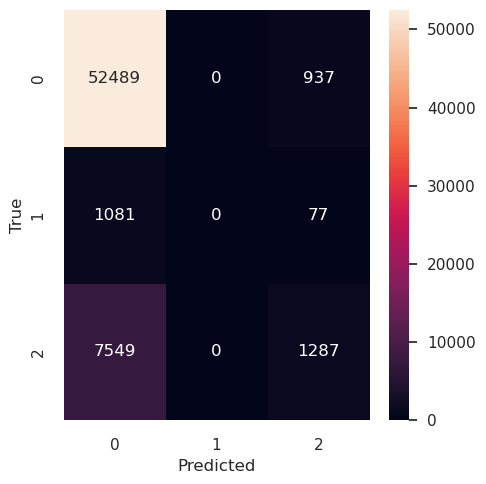

In [84]:
from sklearn.metrics import accuracy_score
print("Training accuracy:")
print(np.round(accuracy_score(y_tr_sk,mn_logit_1.predict(x_tr_sk)),2))
print("Test accuracy:")
print(np.round(accuracy_score(y_true_mn1,y_pred_mn1),2))

from sklearn.metrics import confusion_matrix
sn.set(rc={'figure.figsize':(5,5)})
sn.set(font_scale=1)
matrix = confusion_matrix(y_true_mn1,y_pred_mn1)
sn.heatmap(matrix,annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()

In [85]:
from yellowbrick.classifier import ROCAUC
sn.set(rc={'figure.figsize':(8,5)})
visualizer = ROCAUC(mn_logit_1,classes=[0,1,2])
visualizer.fit(x_tr_sk, y_tr_sk)
visualizer.score(x_tst_sk, y_tst_sk) 
visualizer.show() 

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

The model is performing the worst on prediabetes, which makes sense because it is a very small outcome class. 
Let's try again after oversampling. 


In [86]:
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
counter = Counter(y_tr_sk)
print(counter)
over = SMOTE(sampling_strategy={1:6946},random_state=12 )
#under = RandomUnderSampler(sampling_strategy={0: 6000,2:6000})
steps = [('o', over)]
#steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
trainX_sm ,trainY_sm = pipeline.fit_resample(x_tr_sk, y_tr_sk)

columns_x = x_tr_sk.columns

train_x_smote = pd.DataFrame(data=trainX_sm,columns=columns_x)
train_y_smote = pd.DataFrame(data=trainY_sm,columns=['Diabetes_012'])

counter = Counter(trainY_sm)
print(counter)

Counter({0.0: 160277, 2.0: 26510, 1.0: 3473})
Counter({0.0: 160277, 2.0: 26510, 1.0: 6946})


In [87]:
mn_logit_sm = LogisticRegression(multi_class='multinomial',max_iter=2500)
mn_logit_sm.fit(train_x_smote, train_y_smote.values.ravel())

y_pr_sm = mn_logit_sm.predict(x_tst_sk)

counter = Counter(y_tst_sk)
print(counter)

Counter({0.0: 53426, 2.0: 8836, 1.0: 1158})


In [88]:
sn.set(rc={'figure.figsize':(5,5)})
sn.set(font_scale=1)
matrix = confusion_matrix(y_tst_sk,y_pr_sm)
sn.heatmap(matrix,annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
print("Training accuracy:")
print(np.round(accuracy_score(train_y_smote,mn_logit_sm.predict(train_x_smote)),2))
print("Test accuracy:")
print(np.round(accuracy_score(y_tst_sk,y_pr_sm),2))

Training accuracy:
0.83
Test accuracy:
0.85


In [89]:
sn.set(rc={'figure.figsize':(8,5)})
visualizer = ROCAUC(mn_logit_sm,classes=[0,1,2])
visualizer.fit(train_x_smote, train_y_smote)
visualizer.score(x_tst_sk, y_tst_sk)
visualizer.show() 

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [90]:
counter = Counter(y_tr_sk)
print(counter)
over = SMOTE(sampling_strategy={1:6000},random_state=12 )
under = RandomUnderSampler(sampling_strategy={0: 6000,2:6000})
#steps = [('o', over)]
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
trainX_sm_un,trainY_sm_un = pipeline.fit_resample(x_tr_sk, y_tr_sk)

columns_x = x_tr_sk.columns

train_x_smote_under = pd.DataFrame(data=trainX_sm_un,columns=columns_x)
train_y_smote_under = pd.DataFrame(data=trainY_sm_un,columns=['Diabetes_012'])

counter = Counter(trainY_sm_un)
print(counter)

Counter({0.0: 160277, 2.0: 26510, 1.0: 3473})
Counter({0.0: 6000, 1.0: 6000, 2.0: 6000})


In [91]:

mn_logit_sm_un = LogisticRegression(multi_class='multinomial',max_iter=2500)
mn_logit_sm_un.fit(train_x_smote_under, train_y_smote_under.values.ravel())

y_pr_sm_un = mn_logit_sm_un.predict(x_tst_sk)

counter = Counter(y_tst_sk)
print(counter)

Counter({0.0: 53426, 2.0: 8836, 1.0: 1158})


In [92]:
sn.set(rc={'figure.figsize':(5,5)})
sn.set(font_scale=1)
matrix = confusion_matrix(y_tst_sk,y_pr_sm_un)
sn.heatmap(matrix,annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
print("Training accuracy:")
print(np.round(accuracy_score(train_y_smote_under,mn_logit_sm_un.predict(train_x_smote_under)),2))
print("Test accuracy:")
print(np.round(accuracy_score(y_tst_sk,y_pr_sm_un),2))

Training accuracy:
0.5
Test accuracy:
0.65


What's happening here is that it is predicting the diabetes class, but is now performing a lot worse.

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


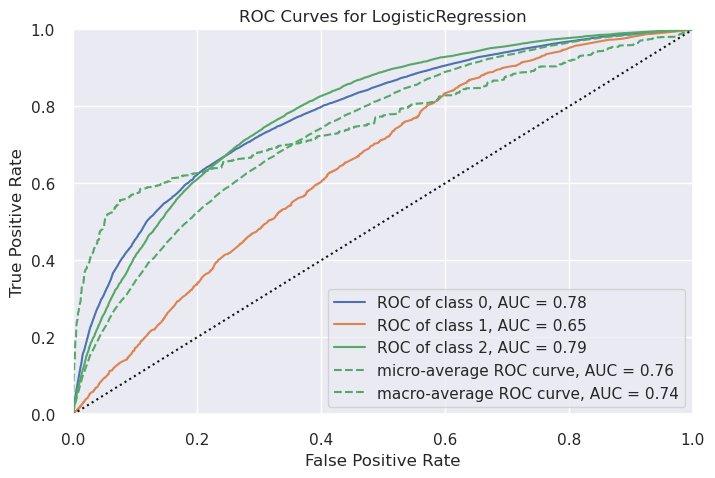

<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [95]:
sn.set(rc={'figure.figsize':(8,5)})
visualizer = ROCAUC(mn_logit_sm_un,classes=[0,1,2])
visualizer.fit(train_x_smote_under, train_y_smote_under)
visualizer.score(x_tst_sk, y_tst_sk) 
visualizer.show() 

In [96]:
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve
#logit_roc_auc = roc_auc_score(testY, logreg.predict_proba(testX), multi_class='ovr')
#fpr, tpr, thresholds = roc_curve(testY, logreg.predict_proba(testX)[:,1],pos_label=1)
#fpr2, tpr2, thresholds2 = roc_curve(testY, logreg.predict_proba(testX)[:,1],pos_label=2)
#plt.figure()
#plt.plot(fpr, tpr, label='Logistic Regression - Diabetes_012 = 1 (area = %0.2f)' % logit_roc_auc)
#plt.plot(fpr2, tpr2, label='Logistic Regression - Diabetes_012 = 2 (area = %0.2f)' % logit_roc_auc)
#plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.legend(loc="lower right")

#plt.show()

In [97]:
from sklearn.feature_selection import RFE
data.head
x_rfe = data.drop(columns=['Diabetes_012'])
y_rfe = data['Diabetes_012']
train_x_rfe, test_x_rfe, train_y_rfe, test_y_rfe = train_test_split(x_rfe, y_rfe, test_size = 0.25, shuffle=True, stratify=y, random_state=0)
mn_logit_rfe = LogisticRegression(multi_class="multinomial",max_iter=2500)
rfe = RFE(mn_logit_rfe)
fit = rfe.fit(train_x_rfe,train_y_rfe)

In [98]:
col = x.columns
RFE_sup = rfe.support_
RFE_rank = rfe.ranking_
dataset = pd.DataFrame({'Columns': col, 'RFE_support': RFE_sup, 'RFE_ranking': RFE_rank}, columns=['Columns', 'RFE_support', 'RFE_ranking'])
df = dataset[(dataset["RFE_support"] == True) & (dataset["RFE_ranking"] == 1)]
filtered_features = df['Columns']
filtered_features

0                  HighBP
1                HighChol
4    HeartDiseaseorAttack
7       HvyAlcoholConsump
9                DiffWalk
Name: Columns, dtype: object

In [99]:
new_train_x_rfe = train_x_rfe[filtered_features]
new_test_x_rfe = test_x_rfe[filtered_features]

In [100]:
model = MNLogit(train_y_rfe, new_train_x_rfe).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.819759
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:           Diabetes_012   No. Observations:               190260
Model:                        MNLogit   Df Residuals:                   190250
Method:                           MLE   Df Model:                            8
Date:                Sun, 23 Jul 2023   Pseudo R-squ.:                 -0.6657
Time:                        17:09:20   Log-Likelihood:            -1.5597e+05
converged:                       True   LL-Null:                       -93637.
Covariance Type:            nonrobust   LLR p-value:                     1.000
      Diabetes_012=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
HighBP                  -2.1189      0.023    -92.655      0.000      -2.164      -2.074

In [101]:
mn_logit_rfe = LogisticRegression(multi_class='multinomial',max_iter = 2500)
mn_logit_rfe.fit(new_train_x_rfe,train_y_rfe)
y_pred_rfe = mn_logit_rfe.predict(new_test_x_rfe)
y_true_rfe = test_y_rfe

Training accuracy:
0.84
Test accuracy:
0.84


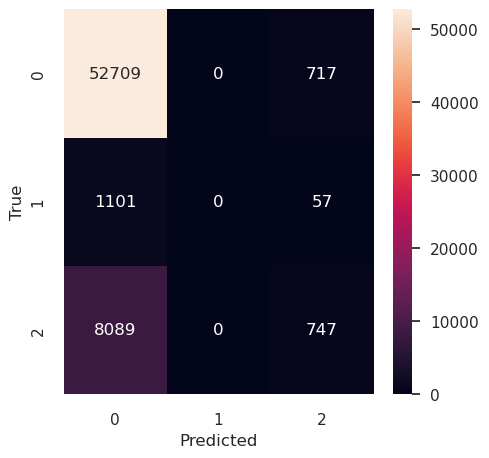

In [102]:
sn.set(rc={'figure.figsize':(5,5)})
sn.set(font_scale=1)
matrix = confusion_matrix(test_y_rfe,y_pred_rfe)
sn.heatmap(matrix,annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
print("Training accuracy:")
print(np.round(accuracy_score(train_y_rfe,mn_logit_rfe.predict(new_train_x_rfe)),2))
print("Test accuracy:")
print(np.round(accuracy_score(test_y_rfe,y_pred_rfe),2))

In [103]:
sn.set(rc={'figure.figsize':(8,5)})
visualizer = ROCAUC(mn_logit_rfe,classes=[0,1,2])
visualizer.fit(new_train_x_rfe, train_y_rfe)
visualizer.score(new_test_x_rfe, test_y_rfe) 
visualizer.show() 

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

### Principal Component Analysis

In [105]:
from sklearn.preprocessing import StandardScaler

y_sc = data['Diabetes_012']
x_sc = data.drop('Diabetes_012',axis=1)

scaler = StandardScaler()
x_tr = scaler.fit_transform(x_sc)


In [106]:
from sklearn.decomposition import PCA
pca = PCA(n_components = None)
pca.fit(x_tr)

PCA()

In [107]:
print('Variance Explained - %')
print(pca.explained_variance_ratio_ * 100)


Variance Explained - %
[21.12854146 11.30853477 10.8604623  10.07943557  9.43710783  8.50370956
  8.00899166  7.85100541  6.68279959  6.13941185]


Text(0, 0.5, 'explained variance')

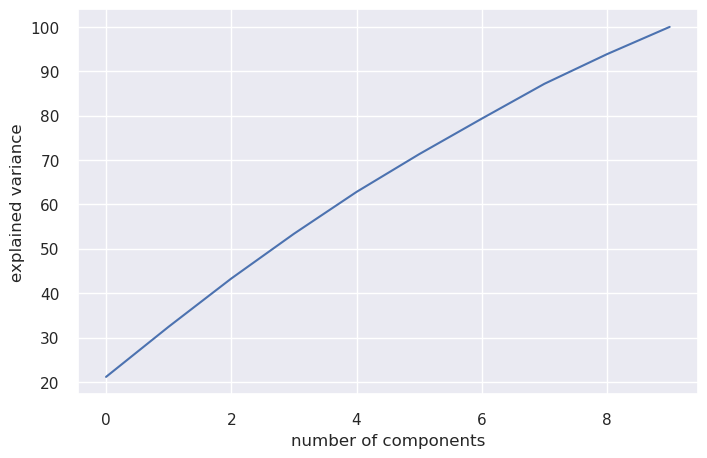

In [108]:
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.xlabel('number of components')
plt.ylabel('explained variance')

Unfortunately we can see that each of the included variables only explains a small portion of the variance in the outcome.